# Restricted Boltzmann Machine - MNIST

## Imports

In [2]:
import sys, datetime
import os

# numpy
import numpy as np
from numpy import exp,sqrt,log,log10,sign,power,cosh,sinh,tanh,floor
rng = np.random.default_rng(12345)
np.set_printoptions(precision=4)

# matplotlib
import matplotlib as mpl
%matplotlib inline
from matplotlib.ticker import NullFormatter, MaxNLocator
mpl.rcParams.update({"font.size": 12})  #"text.usetex": True,})
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# to load MNIST
from sklearn.datasets import fetch_openml

#!mkdir FIG 
#!mkdir FIG/FRAME
#!mkdir WEIGHTS 
#!mkdir DATA
#!mkdir img
#!mkdir img/CV

## Load data

In [3]:
X_original, Y_original = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
#print(X_original.shape)

## Parameters

In [4]:
################################
#    CHOICE OF PARAMETERS      #
################################
# number of MNIST digits to keep (e.g., Ndigit=3 keeps 0,1,2)
Ndigit=3
# number of hidden units
L = 3 ###########SEE Pdf
# use (+1,-1) if SPINS, otherwise use bits (1,0), ising spins
SPINS=False  
# use one-hot encoding in hidden space if POTTS (use only if SPINS=False)
POTTS=False


dname='DATA/'
################################

# x_min =0 if bits, x_min=-1 if SPINS
# level_gap is the difference in values between the max (1) and the min (x_min)
if SPINS:
    x_min=-1
    level_gap=2.
else:
    x_min=0
    level_gap=1.

if POTTS:
    str_simul="RBM_Potts"
    # in one-hot encoding, number of possible hidden states matches L
    Nz=L
else:
    str_simul="RBM"
    # number of possible hidden states: 2**L
    Nz=2**L  # Possible configurations(?)
    
if POTTS and SPINS: 
    print("\n\n>>>>>>>> WARNING:  POTTS and SPINS cannot coexist\n\n")

## Select data, and digitalize them two levels

('7', '8', '9')
dataset with 21076 points, each with 784 bits

first 10 MNIST data points


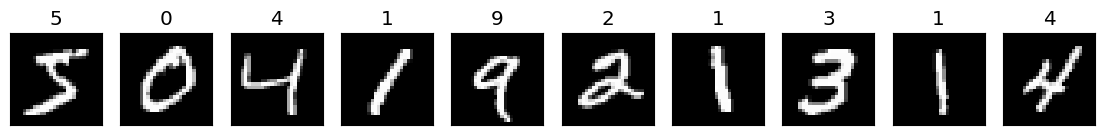

first 10 MNIST-3 data points


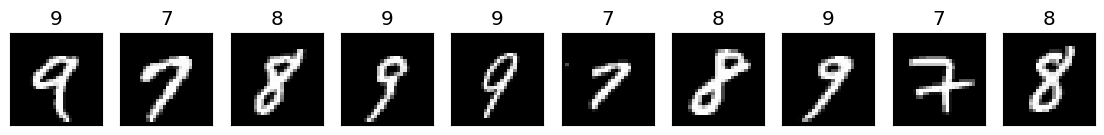

first 10 MNIST-3 data points, binarized


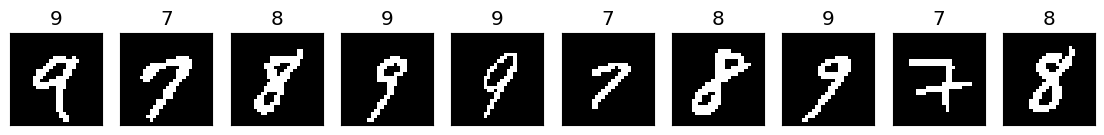

each of Nd=21076 data has D=784 bits


In [5]:
def show_MNIST(x, y=[], z=[], Nex=5, S=1.4, side=0, colors=[]):
    """Show digits"""
    if side==0: side = int(sqrt(x.shape[1]))
    if len(y)<1: y=np.full(Nex,"")
    colors=np.array(colors)
    fig, AX = plt.subplots(1,Nex,figsize=(S*Nex,S))
    
    for i, img in enumerate(x[:Nex].reshape(Nex, side, side)):
        if len(colors)==0: newcmp = "grey"
        else:
            col= colors[0] + (colors[1]-colors[0])*(i+1)/(Nex+1)
            newcmp = ListedColormap((col,(1,1,1,1)))
        ax=AX[i]
        ax.imshow(img, cmap=newcmp)
        ax.set_xticks([])
        ax.set_yticks([])
        if len(y)>0: ax.set_title(y[i])
        if len(z)>0: ax.set_title(''.join(map(str, z[i])),fontsize=9)
    plt.show()

def MNIST_bit(X,side=28,level=0.5):
    NX=len(X)
    #print(X.shape)
    print(f"dataset with {NX} points, each with {len(X[0])} bits\n")
    if side==14:
        X = np.reshape(X,(NX,28,28))
        # new value = average over 4 values in a 2x2 square
        Xr = 0.25*(X[:,0::2,0::2]+X[:,1::2,0::2]+X[:,0::2,1::2]+X[:,1::2,1::2])
        X  = Xr.reshape(NX,side**2)
    #print(X.shape)
    # binarize data and then convert it to 1/0 or 1/-1
    X = np.where(X/255 > level, 1, x_min)
    return X.astype("int")


# Selecting digits to use
list_10_digits = ('0','1','2','3','4','5','6','7','8','9')
list_digits = list_10_digits[-Ndigit:] ########to fine grain set digits  CHOSEN  7-8-9
print(list_digits)

# keep only X and Y in list_digitssssssssss
keep=np.isin(Y_original, list_digits)
X_keep,Y=X_original[keep],Y_original[keep]


data,label = MNIST_bit(X_keep),Y
data,label = data.astype("int"),label.astype("int")
print("first 10 MNIST data points")
show_MNIST(X_original, Y_original,Nex=10)
print(f"first 10 MNIST-{Ndigit} data points")
show_MNIST(X_keep, label,Nex=10)
print(f"first 10 MNIST-{Ndigit} data points, binarized")
show_MNIST(data, label,Nex=10)

# number of data points
Nd = len(data)
# number of visible units - I.e. total pixels of the image
D  = len(data[1])

print(f'each of Nd={Nd} data has D={D} bits')

## Plotting data stats

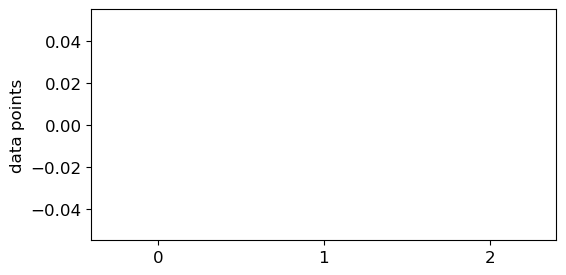

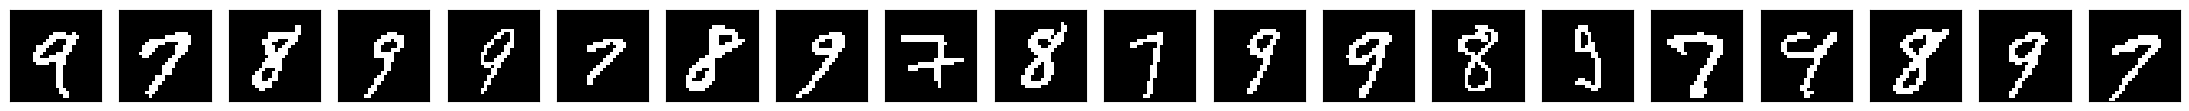

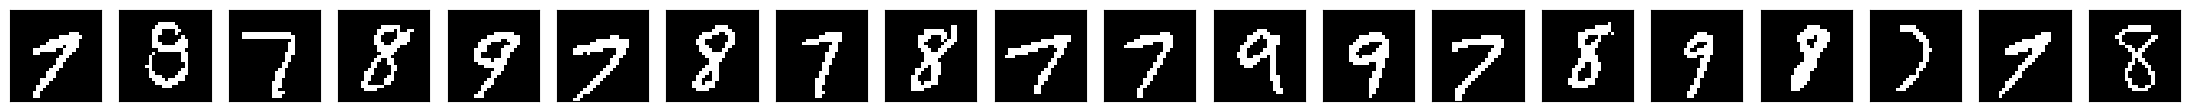

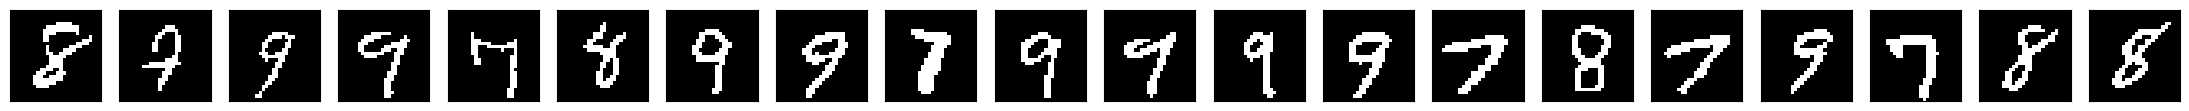

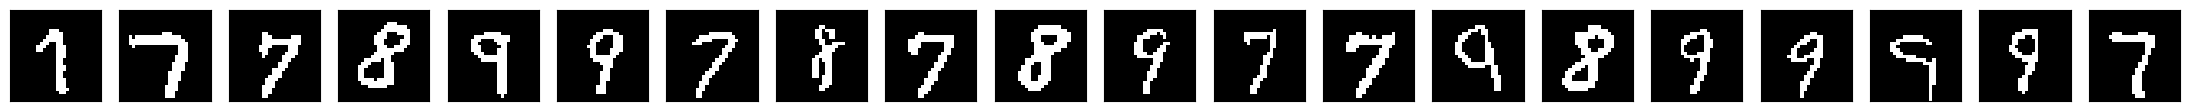

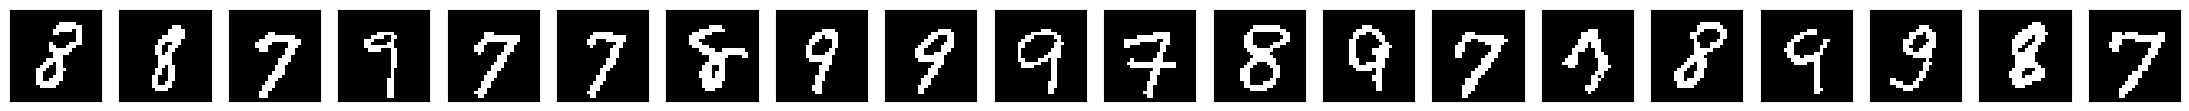

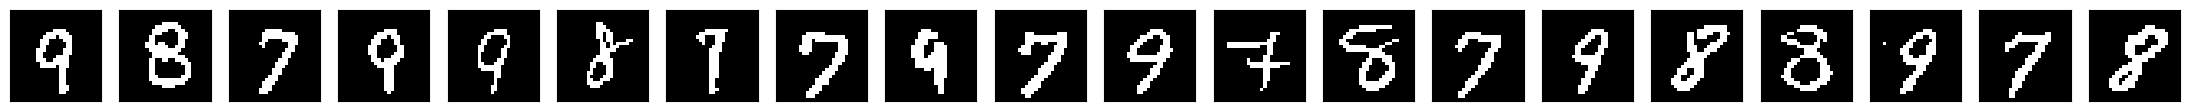

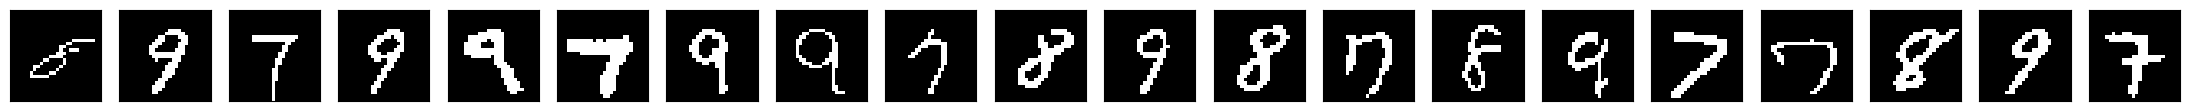

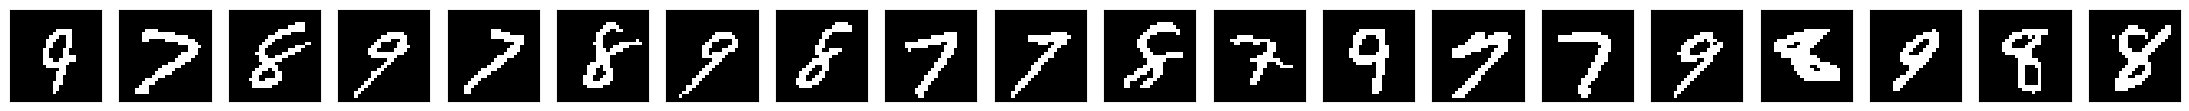

In [6]:
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.hist(np.sort(label),bins=np.arange(Ndigit+1)-1/2,density=False,rwidth=0.55,color="g")#np.sort(label)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.set_ylabel("data points")
plt.show()
for i in range(8): show_MNIST(data[i*20:],Nex=20)

## Contrastive divergence (CD)


In [7]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap 2 for "spin" variables (-1,1)
#@jit(parallel=True)
def CD_step(v_in,wei,bias,details=False,POTTS=False):
    """
        Generates the state on the other layer: 
        Field "H" ->  activation "a" -> probability "p" -> Spins/bits v_out

        Either (v_in=x, wei=w) or (v_in=z, wei=w.T)

        details = True --> returns also probability (p) and activation (a) 

        POTTS means one-hot encoding (used only in hidden space)
    """
    # local "field"
    
    # H is b + v*w
    H = np.clip(np.dot(v_in.astype(np.float64), wei) + bias, a_min=-300, a_max=300)
    # "activation" note, it is a sigmoid freud
    a = np.exp(level_gap*H)
    n = np.shape(H)
    v_out = np.full(n, x_min, dtype=int) # initially, just a list on -1's or 0's
    if POTTS: # RBM with a single hidden unit = 1 (that is, "one-hot encoding" with L states)
        # p: state probability, normalized to 1 over all units=states
        
        # Probability of turning on a hidden unit
        p = a/np.sum(a)
        # F: cumulative probability
        F = np.cumsum(p)
        # pick a state "i" randomly with probability p[i]
        r = np.random.rand()
        i = 0
        while r>F[i]:
            i+=1
        v_out[i] = 1 # activate a single hidden unit
    else: # normal Ising RBM
        # p: local probability, normalized to 1 for each hidden unit
        p = a / (a + 1.)
        # at each position i, activate the 1's with local probability p[i]
        v_out[np.random.random_sample(n) < p] = 1 

    if details: return (v_out,p,a)
    else: return v_out

## Plot weights

In [8]:
def plot_weights_bias(wE, bE, epoch, L, 
                      side=0,cols=0,thr=0,s=1.5, 
                      title=False, save=True,cmap="bwr"):
    '''
    Plot the weights of the RBM, one plot for each hidden unit.
    '''
    rows = int(np.ceil(L / cols))
    if rows==1: rows=2
    w=wE[epoch]
    b=bE[epoch]
    if side==0: side=int(sqrt(len(w)))
    if thr==0: thr=4
    plt.clf()
    fig, AX = plt.subplots(rows, cols+1, figsize=(s*(1+cols),s*rows))
    if title: fig.suptitle(f"epoch = {epoch}")
    k=1
    for i in range(rows):
        for j in range(cols):
            if rows==1: ax=AX[j+1]
            else: ax=AX[i,j+1]
            if k<=L:
                ax.imshow(w[:,k-1].reshape(side, side), cmap=cmap,vmin=-thr,vmax=thr)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title(f"hidden {k}")
            else: fig.delaxes(ax)
            k+=1
        if i>0:  fig.delaxes(AX[i,0])
    
    ax=AX[0,0];
    im=ax.imshow(b.reshape(side, side), cmap=cmap,vmin=-thr,vmax=thr)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("bias")
    # colobar
    cbar_ax = fig.add_axes([0.14, 0.15, 0.024, 0.33])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=12)
    
    S=0.3
    plt.subplots_adjust(hspace=S)

    if save: plt.savefig(f"./FIG/FRAME/RBM_{epoch}_w-a.png")

    plt.show()
    plt.close()


## Weights initialization 

In [9]:
# initial bias of visible units, based on their average value in the dataset
# Hinton, "A Practical Guide to Training Restricted Boltzmann Machines"
def Hinton_bias_init(x):
    '''
    x ::shape of 'x'(data): (21770,784)
    xmean :: does the mean on 'data' for each column -> shape of xmean :(,784)
     xmin =0, xmax=1 if SPINS=FALSE, otherwise {-1,+1}
    since np.precision is set at 4 -> S = 1e-4
    level_gap :: is the difference in values between the max (1) and the min (x_min)
    np.clip :: avoid minimum maximum overflow, inf and -inf values.
    '''
    xmean=np.array(np.mean(x,axis=0))
    # remove values at extrema, to avoid divergences in the log's
    S = 1e-4
    x1,x2 = x_min+S,1-S 
    xmean[xmean<x1] = x1
    xmean[xmean>x2] = x2
    return (1/level_gap)*np.clip(log(xmean-x_min) - log(1-xmean),-300,300)
    
# range of each initial weight
# Glorot and Bengio, "Understanding the difficulty of training deep feedforward neural networks"
sigma = sqrt(4. / float(L + D))

## Gradient descent method

In [10]:
# Gradient descent options
GRAD_list=["SGD","RMSprop"]
GRAD=GRAD_list[1]
if GRAD=="SGD":
    l_rate_ini,l_rate_fin=1.0,0.25
if GRAD=="RMSprop":
    beta,epsilon=0.9,1e-4
    l_rate_ini,l_rate_fin=0.05,0.05
    print("epsilon=",epsilon)
gamma = 0.001 ######### for regularization

print(f"D={D}\tsample size\nL={L}\tnr. z states")
print("Gradient descent type:",GRAD)
print(f"learning rate        = {l_rate_ini} --> {l_rate_fin}")
if gamma!=0: print(f"gamma={gamma}\tregularization")

epsilon= 0.0001
D=784	sample size
L=3	nr. z states
Gradient descent type: RMSprop
learning rate        = 0.05 --> 0.05
gamma=0.001	regularization


### Log-Likelihood

In [11]:
import numpy as np
import itertools as it

#This code has been optimized with the help of chatGPT 4o. It is now clear the importance of using numpy array instead of lists when dealing with repeated operations, and that appending to a vector is 
# not optimized, instead is better to initialize a scalar and accumulate to it. Also important to do all possible operations outside of loops.
#@jit(parallel=True)
def generate_configurations(L):
    """Generate all binary configurations of length L."""
    return np.array(list(it.product((0,1), repeat=L)), dtype=np.int64)
#@jit(parallel=True)
def compute_log_likelihood(partition,data, a, b, w):
    log_likelihoods = np.zeros(len(data))  # Preallocate array
    all_conf = generate_configurations(L)  # Compute binary configs once

    Hz_cache = np.array([H(z) for z in all_conf])  # Precompute H(z)

    for i, x in enumerate(data): 
        Z_x = 0.0
        for Hz, z in zip(Hz_cache, all_conf):
            E_xz = -np.dot(Hz, x) - np.dot(b, z)
            Z_x += np.exp(-E_xz)

        log_likelihoods[i] = np.clip(np.log(Z_x) - partition, a_min=-700, a_max=+7000)

    return np.mean(log_likelihoods)

def H(z):  
    return a + np.dot(w, z)  

def G(z):  
    return np.prod(np.exp(b * z))
#@jit(parallel=True)

#@jit(forceobj=True, looplift=True)
def partition_function(configurations):
    #all_conf = generate_configurations(L)
    sum_values = 0.0  # Use scalar accumulation

    for z in configurations:
        Hz = H(z)
        produttoria_H = np.prod(1 + np.exp(Hz))
        sum_values += G(z) * produttoria_H

    return np.log(sum_values)





### 'RANDOM SEARCH'

In [101]:
import time

np.random.seed(int(time.time()))
## Hyper parameters::

L = np.random.choice(np.arange(8,9,1))
print(f'L, hidden units: {L}')
SPINS = False#np.random.choice([True, False])
print(f'SPINS: {SPINS}')
POTTS = np.random.choice([True, False])
print(f'POTTS: {POTTS}')
gamma = np.random.choice([0, 1e-1,1e-2,1e-3,1e-4,1e-5])
print(f'gamma: {gamma}')
GRAD = np.random.choice(['SGD', 'RMSprop'])
print(f'GRAD: {GRAD}')
Nt = np.random.choice(np.arange(1, 3,1))
print(f'Nt: {Nt}')
Nepoch = np.random.choice(np.arange(100, 151,25))
print(f'Epochs: {Nepoch}')
Nmini = np.random.choice(np.arange(5, 51,5))
print(f'Nmini: {Nmini}')
N_ini = np.random.choice(np.arange(5, 51,5))
print(f'Nini: {N_ini}')
N_fin = np.random.choice(np.arange(50, 400,25))
print(f'Nfin: {N_fin}')


## Prof. setup for gradient choice & gamma
if GRAD=="SGD":
    l_rate_ini,l_rate_fin=1.0,0.25
if GRAD=="RMSprop":
    beta,epsilon=0.9,1e-4
    l_rate_ini,l_rate_fin=0.05,0.05
    print("epsilon=",epsilon)

print(f"D={D}\tsample size\nL={L}\tnr. z states")
print("Gradient descent type:",GRAD)
print(f"learning rate        = {l_rate_ini} --> {l_rate_fin}")
if gamma!=0: print(f"gamma={gamma}\tregularization")

## Prof setup for spin/potts/other thing

if SPINS:
    x_min=-1
    level_gap=2.
else:
    x_min=0
    level_gap=1.

if POTTS:
    str_simul="RBM_Potts"
    # in one-hot encoding, number of possible hidden states matches L
    Nz=L
else:
    str_simul="RBM"
    # number of possible hidden states: 2**L
    Nz=2**L
    
if POTTS and SPINS: 
    print("\n\n>>>>>>>> WARNING:  POTTS and SPINS cannot coexist\n\n")


stringa = f'L:{L}\nSPIN:{SPINS}\nPOTTS:{POTTS}\ngamma:{gamma}\nNt:{Nt}\nNepoch:{Nepoch}\nNmini:{Nmini}\nNini:{N_ini}\nNfin:{N_fin}\nGrad:{GRAD}'

L, hidden units: 8
SPINS: False
POTTS: False
gamma: 0.01
GRAD: RMSprop
Nt: 1
Epochs: 100
Nmini: 50
Nini: 50
Nfin: 200
epsilon= 0.0001
D=784	sample size
L=8	nr. z states
Gradient descent type: RMSprop
learning rate        = 0.05 --> 0.05
gamma=0.01	regularization


# CV

In [37]:
import time
## Hyper parameters::

L = 10
print(f'L, hidden units: {L}')
SPINS = False#np.random.choice([True, False])
print(f'SPINS: {SPINS}')
POTTS = False
print(f'POTTS: {POTTS}')
gamma = .001
print(f'gamma: {gamma}')
GRAD = 'RMSprop'
print(f'GRAD: {GRAD}')
Nt = 7
print(f'Nt: {Nt}')
Nepoch = 300
print(f'Epochs: {Nepoch}')
Nmini = 10
print(f'Nmini: {Nmini}')
N_ini = 5
print(f'Nini: {N_ini}')
N_fin = 325
print(f'Nfin: {N_fin}')


## Prof. setup for gradient choice & gamma
if GRAD=="SGD":
    l_rate_ini,l_rate_fin=1.0,0.25
if GRAD=="RMSprop":
    beta,epsilon=0.9,1e-4
    l_rate_ini,l_rate_fin=0.05,0.05
    print("epsilon=",epsilon)

print(f"D={D}\tsample size\nL={L}\tnr. z states")
print("Gradient descent type:",GRAD)
print(f"learning rate        = {l_rate_ini} --> {l_rate_fin}")
if gamma!=0: print(f"gamma={gamma}\tregularization")

## Prof setup for spin/potts/other thing

if SPINS:
    x_min=-1
    level_gap=2.
else:
    x_min=0
    level_gap=1.

if POTTS:
    str_simul="RBM_Potts"
    # in one-hot encoding, number of possible hidden states matches L
    Nz=L
else:
    str_simul="RBM"
    # number of possible hidden states: 2**L
    Nz=2**L
    
if POTTS and SPINS: 
    print("\n\n>>>>>>>> WARNING:  POTTS and SPINS cannot coexist\n\n")


stringa = f'#L:{L}\n#SPIN:{SPINS}\n#POTTS:{POTTS}\n#gamma:{gamma}\n#Nt:{Nt}\n#Nepoch:{Nepoch}\n#Nmini:{Nmini}\n#Nini:{N_ini}\n#Nfin:{N_fin}\n#Grad:{GRAD}'
with open(f'llh{int(time.time())}.txt', 'a') as add:
    print(stringa, file=add)

L, hidden units: 10
SPINS: False
POTTS: False
gamma: 0.001
GRAD: RMSprop
Nt: 7
Epochs: 300
Nmini: 10
Nini: 5
Nfin: 325
epsilon= 0.0001
D=784	sample size
L=10	nr. z states
Gradient descent type: RMSprop
learning rate        = 0.05 --> 0.05
gamma=0.001	regularization


## CV reale

Nepoch=300
Nmini=10


<Figure size 640x480 with 0 Axes>

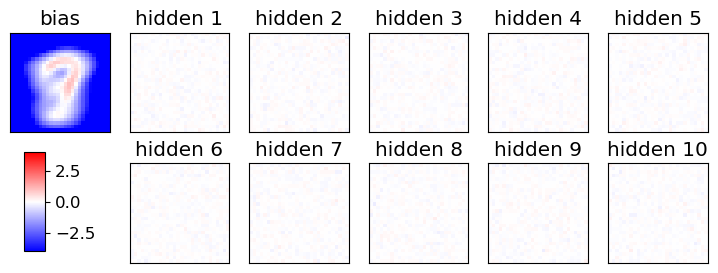

Starting the training
[ 9102  5487 18633  5239 17311]
[ 5404 20421 19488 14748   638]
[  909 16275 15423 10660 15570]
[11878  3434 10075  9748 18924]
epoch 1 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 6 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 9 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 10 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 11 

<Figure size 640x480 with 0 Axes>

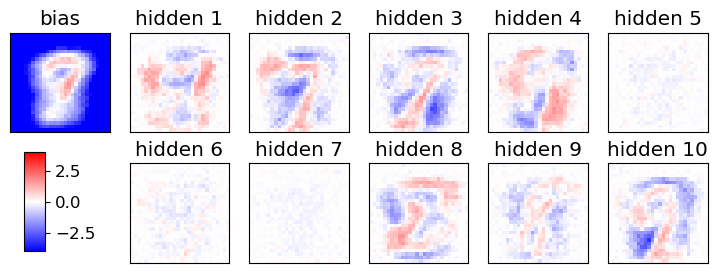

epoch 21 / 300  Nt: 7  N: 6  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 300  Nt: 7  N: 6  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 300  Nt: 7  N: 6  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 300  Nt: 7  N: 6  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 300  Nt: 7  N: 7  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 26 / 300  Nt: 7  N: 7  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 300  Nt: 7  N: 7  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 300  Nt: 7  N: 7  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 300  Nt: 7  N: 7  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 300  Nt: 7  N: 8  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 31 / 300  Nt: 7  N: 8  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 32 / 300  Nt: 7  N: 8  L: 10  rate: 0.05  gam: 0.001 SPINS=

<Figure size 640x480 with 0 Axes>

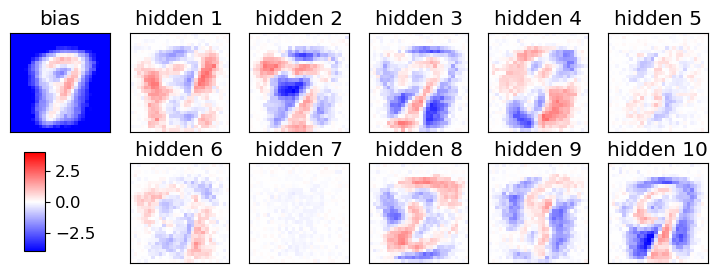

epoch 41 / 300  Nt: 7  N: 10  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 300  Nt: 7  N: 11  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 300  Nt: 7  N: 11  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 300  Nt: 7  N: 11  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 300  Nt: 7  N: 11  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 46 / 300  Nt: 7  N: 12  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 300  Nt: 7  N: 12  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 300  Nt: 7  N: 12  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 300  Nt: 7  N: 13  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 300  Nt: 7  N: 13  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 51 / 300  Nt: 7  N: 13  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 52 / 300  Nt: 7  N: 14  L: 10  rate: 0.05  gam: 

<Figure size 640x480 with 0 Axes>

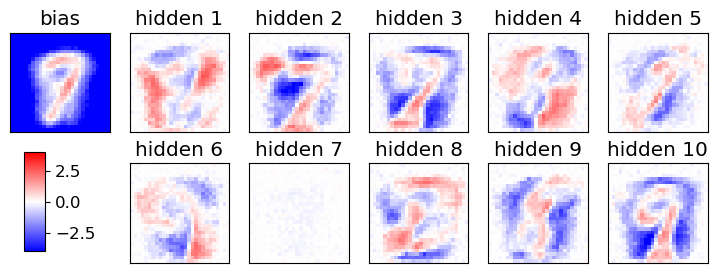

epoch 61 / 300  Nt: 7  N: 17  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 300  Nt: 7  N: 18  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 300  Nt: 7  N: 18  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 300  Nt: 7  N: 19  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 300  Nt: 7  N: 19  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 66 / 300  Nt: 7  N: 20  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 300  Nt: 7  N: 20  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 300  Nt: 7  N: 21  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 300  Nt: 7  N: 21  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 300  Nt: 7  N: 22  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 71 / 300  Nt: 7  N: 22  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 72 / 300  Nt: 7  N: 23  L: 10  rate: 0.05  gam: 

<Figure size 640x480 with 0 Axes>

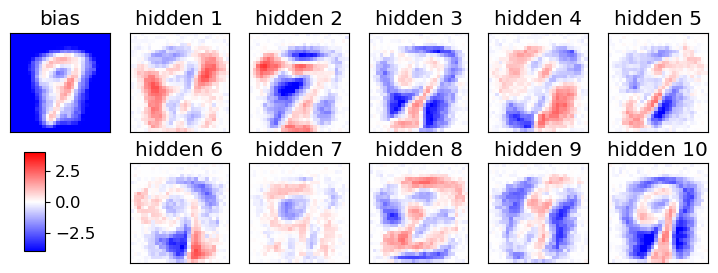

epoch 81 / 300  Nt: 7  N: 27  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 300  Nt: 7  N: 28  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 300  Nt: 7  N: 29  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 300  Nt: 7  N: 29  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 300  Nt: 7  N: 30  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 86 / 300  Nt: 7  N: 30  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 300  Nt: 7  N: 31  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 300  Nt: 7  N: 32  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 300  Nt: 7  N: 32  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 300  Nt: 7  N: 33  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 91 / 300  Nt: 7  N: 33  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 92 / 300  Nt: 7  N: 34  L: 10  rate: 0.05  gam: 

<Figure size 640x480 with 0 Axes>

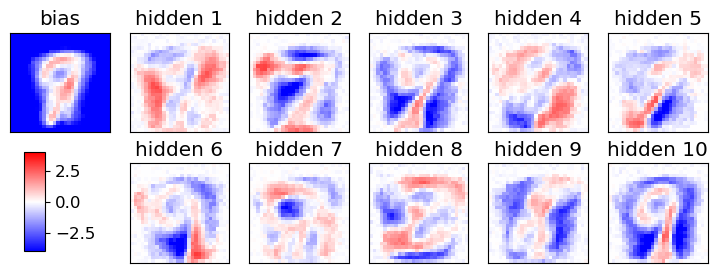

epoch 101 / 300  Nt: 7  N: 40  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 300  Nt: 7  N: 41  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 300  Nt: 7  N: 42  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 300  Nt: 7  N: 42  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 300  Nt: 7  N: 43  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 106 / 300  Nt: 7  N: 44  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 300  Nt: 7  N: 45  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 300  Nt: 7  N: 45  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 300  Nt: 7  N: 46  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 300  Nt: 7  N: 47  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 111 / 300  Nt: 7  N: 48  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 112 / 300  Nt: 7  N: 49  L: 10  rate:

<Figure size 640x480 with 0 Axes>

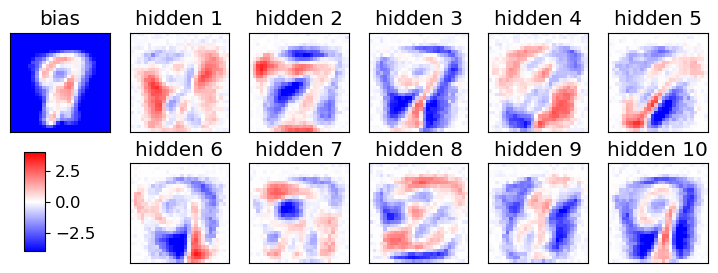

epoch 121 / 300  Nt: 7  N: 56  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 300  Nt: 7  N: 57  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 300  Nt: 7  N: 58  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 300  Nt: 7  N: 59  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 300  Nt: 7  N: 60  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 126 / 300  Nt: 7  N: 60  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 300  Nt: 7  N: 61  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 300  Nt: 7  N: 62  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 300  Nt: 7  N: 63  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 300  Nt: 7  N: 64  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 131 / 300  Nt: 7  N: 65  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 132 / 300  Nt: 7  N: 66  L: 10  rate:

<Figure size 640x480 with 0 Axes>

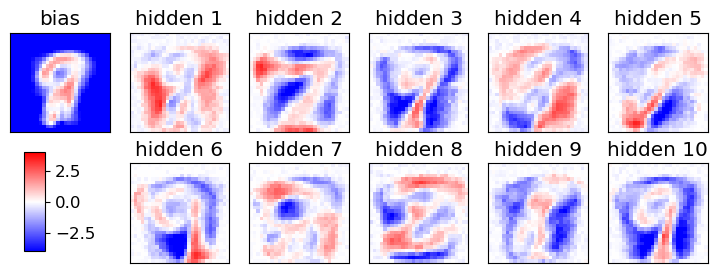

epoch 141 / 300  Nt: 7  N: 75  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 142 / 300  Nt: 7  N: 76  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 143 / 300  Nt: 7  N: 77  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 144 / 300  Nt: 7  N: 78  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 145 / 300  Nt: 7  N: 79  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 146 / 300  Nt: 7  N: 80  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 147 / 300  Nt: 7  N: 81  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 148 / 300  Nt: 7  N: 82  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 149 / 300  Nt: 7  N: 83  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 150 / 300  Nt: 7  N: 84  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 151 / 300  Nt: 7  N: 85  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 152 / 300  Nt: 7  N: 86  L: 10  rate:

<Figure size 640x480 with 0 Axes>

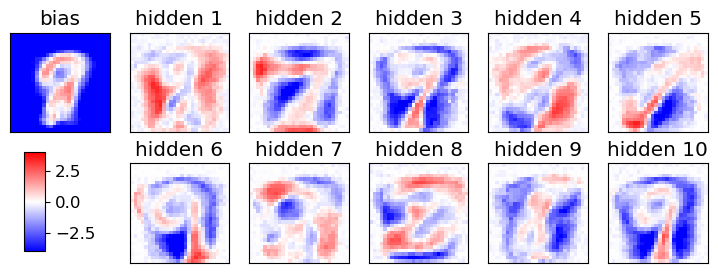

epoch 161 / 300  Nt: 7  N: 96  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 162 / 300  Nt: 7  N: 97  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 163 / 300  Nt: 7  N: 98  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 164 / 300  Nt: 7  N: 100  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 165 / 300  Nt: 7  N: 101  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 166 / 300  Nt: 7  N: 102  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 167 / 300  Nt: 7  N: 103  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 168 / 300  Nt: 7  N: 104  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 169 / 300  Nt: 7  N: 106  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 170 / 300  Nt: 7  N: 107  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 171 / 300  Nt: 7  N: 108  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 172 / 300  Nt: 7  N: 109  L: 

<Figure size 640x480 with 0 Axes>

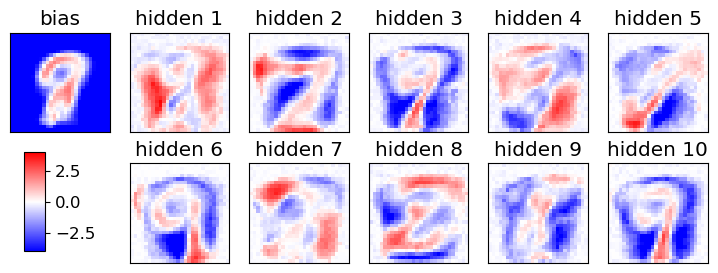

epoch 181 / 300  Nt: 7  N: 120  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 182 / 300  Nt: 7  N: 122  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 183 / 300  Nt: 7  N: 123  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 184 / 300  Nt: 7  N: 124  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 185 / 300  Nt: 7  N: 126  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 186 / 300  Nt: 7  N: 127  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 187 / 300  Nt: 7  N: 128  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 188 / 300  Nt: 7  N: 130  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 189 / 300  Nt: 7  N: 131  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 190 / 300  Nt: 7  N: 132  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 191 / 300  Nt: 7  N: 134  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 192 / 300  Nt: 7  N: 135  

<Figure size 640x480 with 0 Axes>

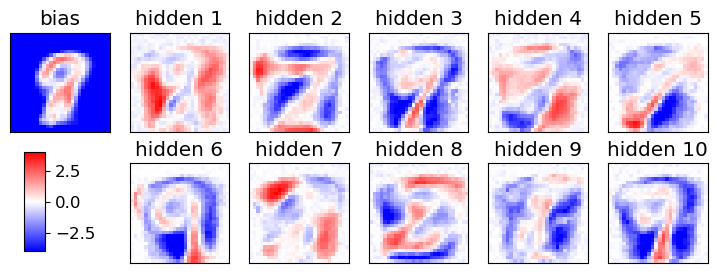

epoch 201 / 300  Nt: 7  N: 148  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 202 / 300  Nt: 7  N: 149  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 203 / 300  Nt: 7  N: 151  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 204 / 300  Nt: 7  N: 152  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 205 / 300  Nt: 7  N: 153  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 206 / 300  Nt: 7  N: 155  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 207 / 300  Nt: 7  N: 156  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 208 / 300  Nt: 7  N: 158  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 209 / 300  Nt: 7  N: 159  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 210 / 300  Nt: 7  N: 161  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 211 / 300  Nt: 7  N: 162  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 212 / 300  Nt: 7  N: 164  

<Figure size 640x480 with 0 Axes>

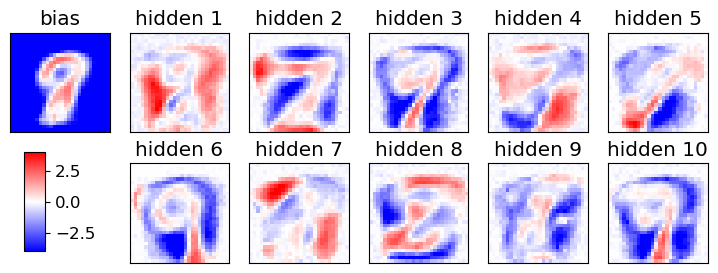

epoch 221 / 300  Nt: 7  N: 178  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 222 / 300  Nt: 7  N: 179  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 223 / 300  Nt: 7  N: 181  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 224 / 300  Nt: 7  N: 182  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 225 / 300  Nt: 7  N: 184  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 226 / 300  Nt: 7  N: 186  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 227 / 300  Nt: 7  N: 187  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 228 / 300  Nt: 7  N: 189  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 229 / 300  Nt: 7  N: 191  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 230 / 300  Nt: 7  N: 192  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 231 / 300  Nt: 7  N: 194  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 232 / 300  Nt: 7  N: 195  

<Figure size 640x480 with 0 Axes>

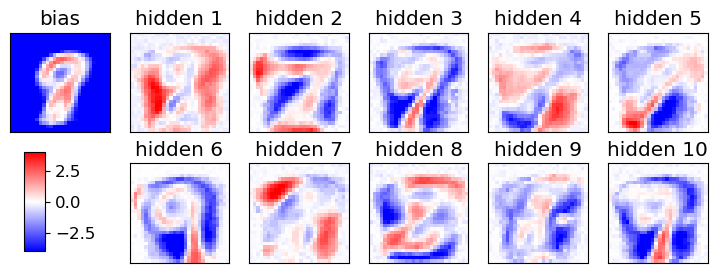

epoch 241 / 300  Nt: 7  N: 211  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 242 / 300  Nt: 7  N: 212  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 243 / 300  Nt: 7  N: 214  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 244 / 300  Nt: 7  N: 216  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 245 / 300  Nt: 7  N: 218  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 246 / 300  Nt: 7  N: 219  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 247 / 300  Nt: 7  N: 221  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 248 / 300  Nt: 7  N: 223  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 249 / 300  Nt: 7  N: 225  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 250 / 300  Nt: 7  N: 226  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 251 / 300  Nt: 7  N: 228  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 252 / 300  Nt: 7  N: 230  

<Figure size 640x480 with 0 Axes>

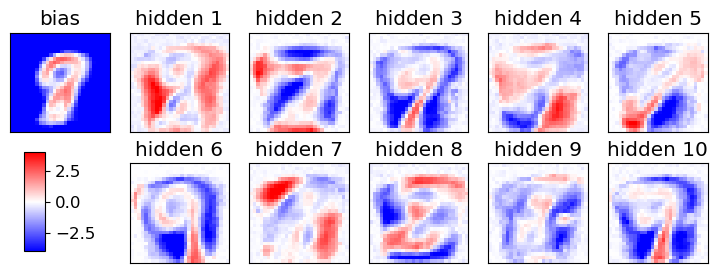

epoch 261 / 300  Nt: 7  N: 246  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 262 / 300  Nt: 7  N: 248  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 263 / 300  Nt: 7  N: 250  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 264 / 300  Nt: 7  N: 252  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 265 / 300  Nt: 7  N: 254  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 266 / 300  Nt: 7  N: 256  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 267 / 300  Nt: 7  N: 258  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 268 / 300  Nt: 7  N: 260  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 269 / 300  Nt: 7  N: 262  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 270 / 300  Nt: 7  N: 264  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 271 / 300  Nt: 7  N: 265  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 272 / 300  Nt: 7  N: 267  

<Figure size 640x480 with 0 Axes>

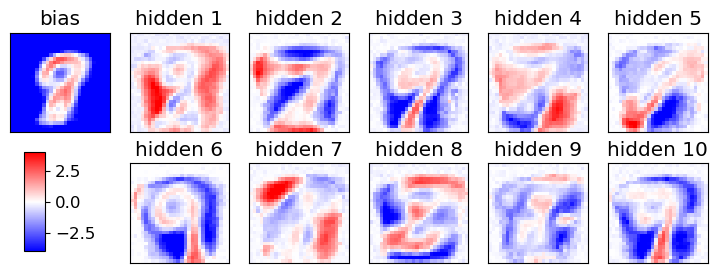

epoch 281 / 300  Nt: 7  N: 285  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 282 / 300  Nt: 7  N: 287  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 283 / 300  Nt: 7  N: 289  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 284 / 300  Nt: 7  N: 291  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 285 / 300  Nt: 7  N: 293  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 286 / 300  Nt: 7  N: 295  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 287 / 300  Nt: 7  N: 297  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 288 / 300  Nt: 7  N: 299  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 289 / 300  Nt: 7  N: 301  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 290 / 300  Nt: 7  N: 303  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 291 / 300  Nt: 7  N: 306  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 292 / 300  Nt: 7  N: 308  

<Figure size 640x480 with 0 Axes>

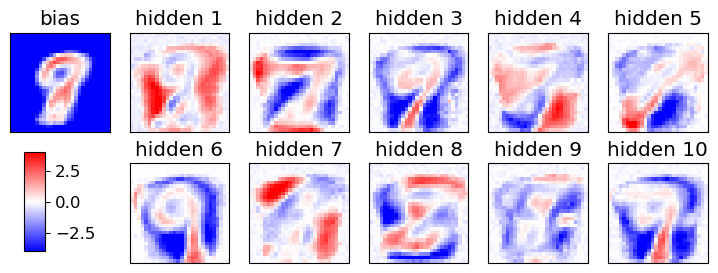

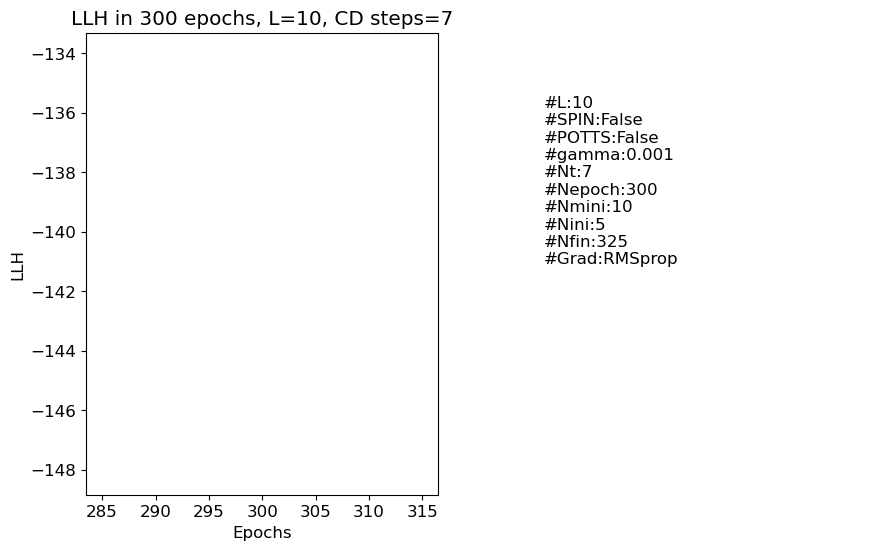

END of learning phase
Nepoch=300
Nmini=10


<Figure size 640x480 with 0 Axes>

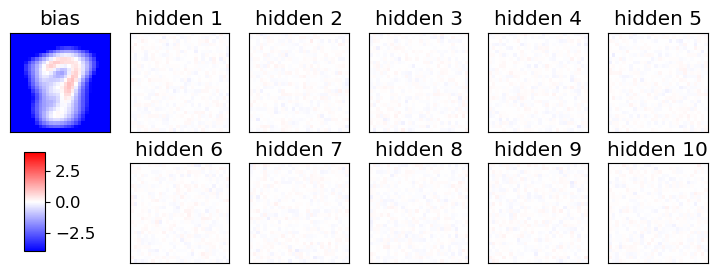

Starting the training
[11064  2750 16836 13173  7547]
[19128 12506  8535 13291  7565]
[ 9658 11131  1309 13572  5534]
[ 8129 20371  4232  1287 19936]
epoch 1 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 6 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 9 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 10 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 11 

<Figure size 640x480 with 0 Axes>

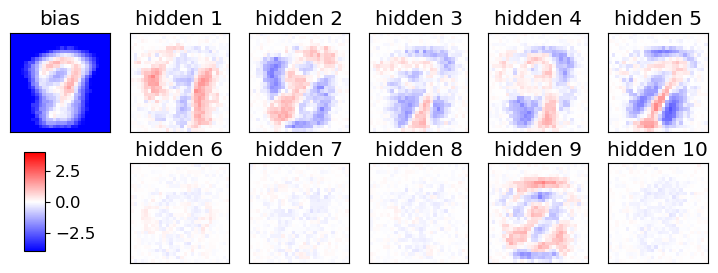

epoch 21 / 300  Nt: 7  N: 6  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 300  Nt: 7  N: 6  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 300  Nt: 7  N: 6  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 300  Nt: 7  N: 6  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 300  Nt: 7  N: 7  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 26 / 300  Nt: 7  N: 7  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 300  Nt: 7  N: 7  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 300  Nt: 7  N: 7  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 300  Nt: 7  N: 7  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 300  Nt: 7  N: 8  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 31 / 300  Nt: 7  N: 8  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 32 / 300  Nt: 7  N: 8  L: 10  rate: 0.05  gam: 0.001 SPINS=

<Figure size 640x480 with 0 Axes>

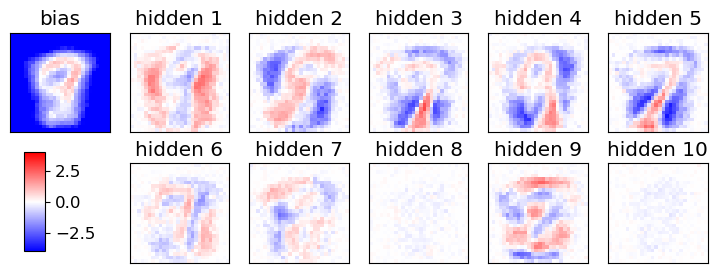

epoch 41 / 300  Nt: 7  N: 10  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 300  Nt: 7  N: 11  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 300  Nt: 7  N: 11  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 300  Nt: 7  N: 11  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 300  Nt: 7  N: 11  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 46 / 300  Nt: 7  N: 12  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 300  Nt: 7  N: 12  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 300  Nt: 7  N: 12  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 300  Nt: 7  N: 13  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 300  Nt: 7  N: 13  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 51 / 300  Nt: 7  N: 13  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 52 / 300  Nt: 7  N: 14  L: 10  rate: 0.05  gam: 

<Figure size 640x480 with 0 Axes>

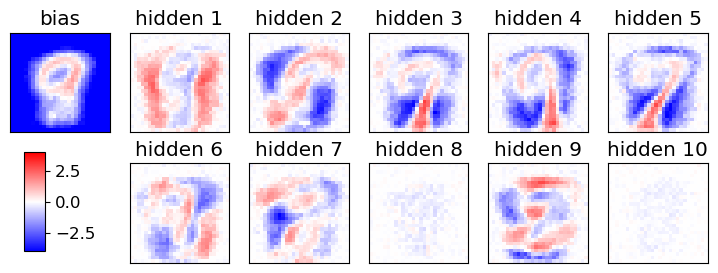

epoch 61 / 300  Nt: 7  N: 17  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 300  Nt: 7  N: 18  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 300  Nt: 7  N: 18  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 300  Nt: 7  N: 19  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 300  Nt: 7  N: 19  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 66 / 300  Nt: 7  N: 20  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 300  Nt: 7  N: 20  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 300  Nt: 7  N: 21  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 300  Nt: 7  N: 21  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 300  Nt: 7  N: 22  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 71 / 300  Nt: 7  N: 22  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 72 / 300  Nt: 7  N: 23  L: 10  rate: 0.05  gam: 

<Figure size 640x480 with 0 Axes>

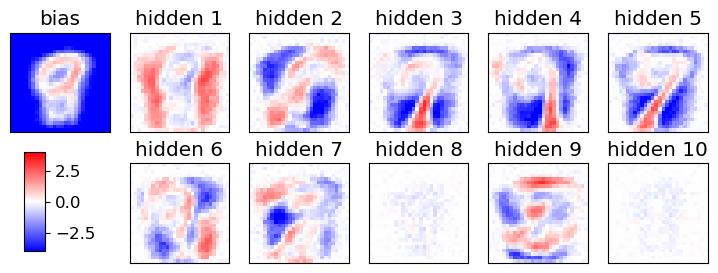

epoch 81 / 300  Nt: 7  N: 27  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 300  Nt: 7  N: 28  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 300  Nt: 7  N: 29  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 300  Nt: 7  N: 29  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 300  Nt: 7  N: 30  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 86 / 300  Nt: 7  N: 30  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 300  Nt: 7  N: 31  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 300  Nt: 7  N: 32  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 300  Nt: 7  N: 32  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 300  Nt: 7  N: 33  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 91 / 300  Nt: 7  N: 33  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 92 / 300  Nt: 7  N: 34  L: 10  rate: 0.05  gam: 

<Figure size 640x480 with 0 Axes>

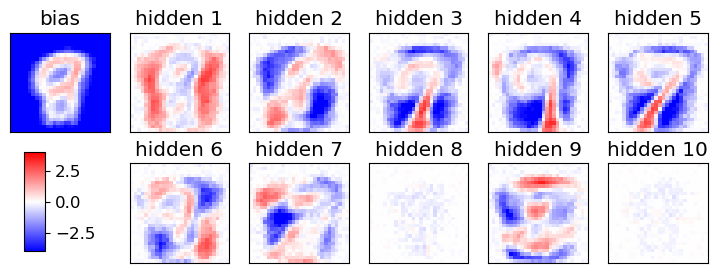

epoch 101 / 300  Nt: 7  N: 40  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 300  Nt: 7  N: 41  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 300  Nt: 7  N: 42  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 300  Nt: 7  N: 42  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 300  Nt: 7  N: 43  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 106 / 300  Nt: 7  N: 44  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 300  Nt: 7  N: 45  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 300  Nt: 7  N: 45  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 300  Nt: 7  N: 46  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 300  Nt: 7  N: 47  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 111 / 300  Nt: 7  N: 48  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 112 / 300  Nt: 7  N: 49  L: 10  rate:

<Figure size 640x480 with 0 Axes>

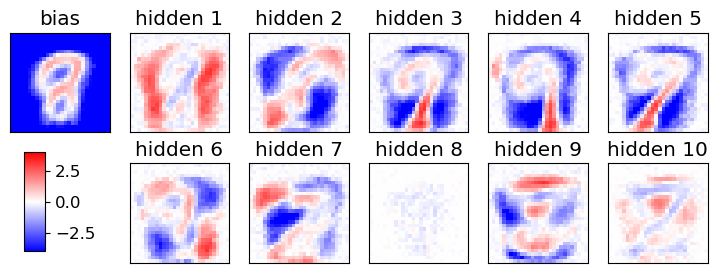

epoch 121 / 300  Nt: 7  N: 56  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 300  Nt: 7  N: 57  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 300  Nt: 7  N: 58  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 300  Nt: 7  N: 59  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 300  Nt: 7  N: 60  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 126 / 300  Nt: 7  N: 60  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 300  Nt: 7  N: 61  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 300  Nt: 7  N: 62  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 300  Nt: 7  N: 63  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 300  Nt: 7  N: 64  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 131 / 300  Nt: 7  N: 65  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 132 / 300  Nt: 7  N: 66  L: 10  rate:

<Figure size 640x480 with 0 Axes>

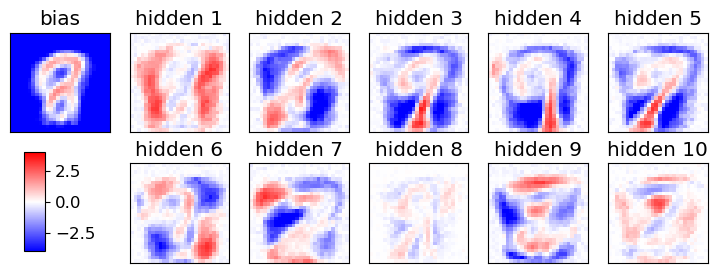

epoch 141 / 300  Nt: 7  N: 75  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 142 / 300  Nt: 7  N: 76  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 143 / 300  Nt: 7  N: 77  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 144 / 300  Nt: 7  N: 78  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 145 / 300  Nt: 7  N: 79  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 146 / 300  Nt: 7  N: 80  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 147 / 300  Nt: 7  N: 81  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 148 / 300  Nt: 7  N: 82  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 149 / 300  Nt: 7  N: 83  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 150 / 300  Nt: 7  N: 84  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 151 / 300  Nt: 7  N: 85  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 152 / 300  Nt: 7  N: 86  L: 10  rate:

<Figure size 640x480 with 0 Axes>

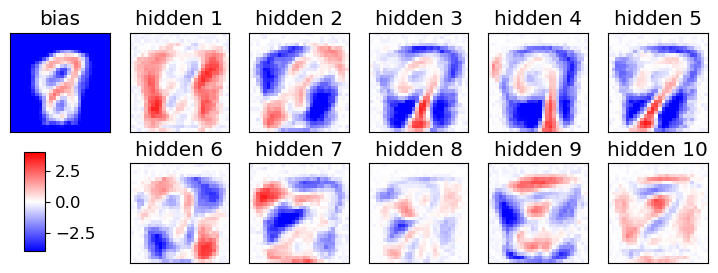

epoch 161 / 300  Nt: 7  N: 96  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 162 / 300  Nt: 7  N: 97  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 163 / 300  Nt: 7  N: 98  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 164 / 300  Nt: 7  N: 100  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 165 / 300  Nt: 7  N: 101  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 166 / 300  Nt: 7  N: 102  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 167 / 300  Nt: 7  N: 103  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 168 / 300  Nt: 7  N: 104  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 169 / 300  Nt: 7  N: 106  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 170 / 300  Nt: 7  N: 107  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 171 / 300  Nt: 7  N: 108  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 172 / 300  Nt: 7  N: 109  L: 

<Figure size 640x480 with 0 Axes>

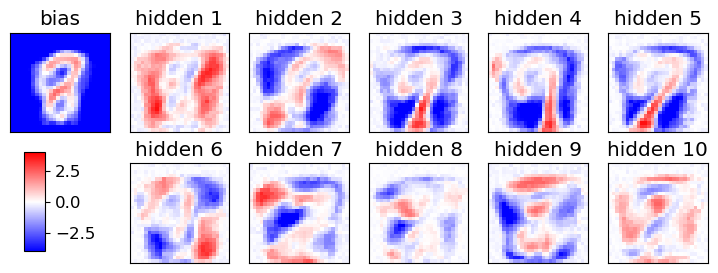

epoch 181 / 300  Nt: 7  N: 120  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 182 / 300  Nt: 7  N: 122  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 183 / 300  Nt: 7  N: 123  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 184 / 300  Nt: 7  N: 124  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 185 / 300  Nt: 7  N: 126  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 186 / 300  Nt: 7  N: 127  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 187 / 300  Nt: 7  N: 128  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 188 / 300  Nt: 7  N: 130  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 189 / 300  Nt: 7  N: 131  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 190 / 300  Nt: 7  N: 132  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 191 / 300  Nt: 7  N: 134  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 192 / 300  Nt: 7  N: 135  

<Figure size 640x480 with 0 Axes>

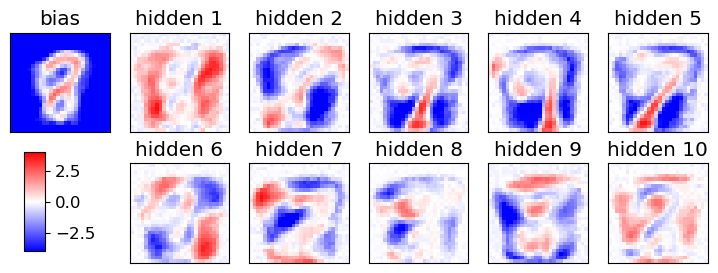

epoch 201 / 300  Nt: 7  N: 148  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 202 / 300  Nt: 7  N: 149  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 203 / 300  Nt: 7  N: 151  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 204 / 300  Nt: 7  N: 152  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 205 / 300  Nt: 7  N: 153  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 206 / 300  Nt: 7  N: 155  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 207 / 300  Nt: 7  N: 156  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 208 / 300  Nt: 7  N: 158  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 209 / 300  Nt: 7  N: 159  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 210 / 300  Nt: 7  N: 161  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 211 / 300  Nt: 7  N: 162  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 212 / 300  Nt: 7  N: 164  

<Figure size 640x480 with 0 Axes>

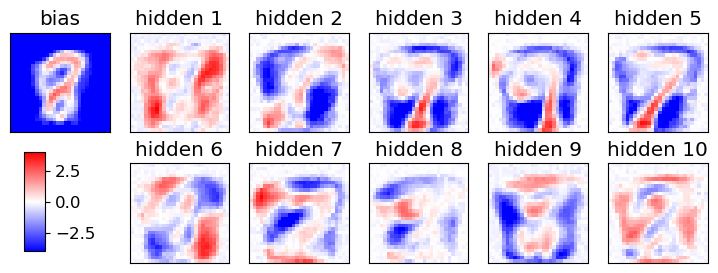

epoch 221 / 300  Nt: 7  N: 178  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 222 / 300  Nt: 7  N: 179  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 223 / 300  Nt: 7  N: 181  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 224 / 300  Nt: 7  N: 182  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 225 / 300  Nt: 7  N: 184  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 226 / 300  Nt: 7  N: 186  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 227 / 300  Nt: 7  N: 187  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 228 / 300  Nt: 7  N: 189  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 229 / 300  Nt: 7  N: 191  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 230 / 300  Nt: 7  N: 192  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 231 / 300  Nt: 7  N: 194  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 232 / 300  Nt: 7  N: 195  

<Figure size 640x480 with 0 Axes>

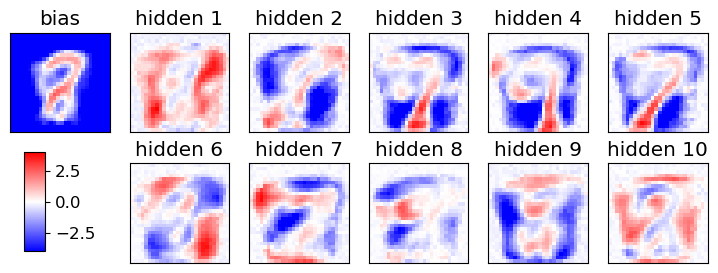

epoch 241 / 300  Nt: 7  N: 211  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 242 / 300  Nt: 7  N: 212  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 243 / 300  Nt: 7  N: 214  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 244 / 300  Nt: 7  N: 216  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 245 / 300  Nt: 7  N: 218  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 246 / 300  Nt: 7  N: 219  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 247 / 300  Nt: 7  N: 221  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 248 / 300  Nt: 7  N: 223  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 249 / 300  Nt: 7  N: 225  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 250 / 300  Nt: 7  N: 226  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 251 / 300  Nt: 7  N: 228  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 252 / 300  Nt: 7  N: 230  

<Figure size 640x480 with 0 Axes>

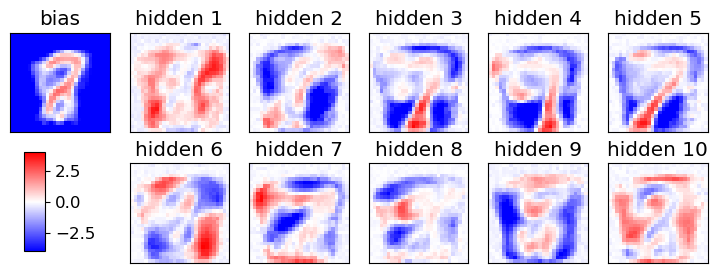

epoch 261 / 300  Nt: 7  N: 246  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 262 / 300  Nt: 7  N: 248  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 263 / 300  Nt: 7  N: 250  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 264 / 300  Nt: 7  N: 252  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 265 / 300  Nt: 7  N: 254  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 266 / 300  Nt: 7  N: 256  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 267 / 300  Nt: 7  N: 258  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 268 / 300  Nt: 7  N: 260  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 269 / 300  Nt: 7  N: 262  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 270 / 300  Nt: 7  N: 264  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 271 / 300  Nt: 7  N: 265  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 272 / 300  Nt: 7  N: 267  

<Figure size 640x480 with 0 Axes>

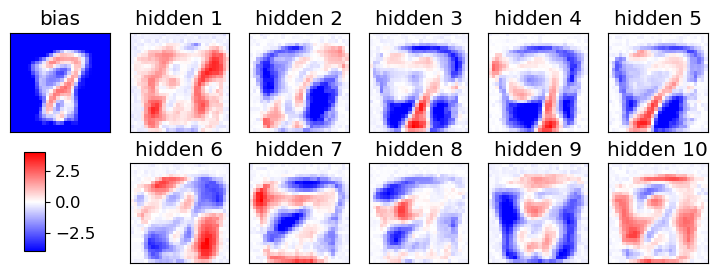

epoch 281 / 300  Nt: 7  N: 285  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 282 / 300  Nt: 7  N: 287  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 283 / 300  Nt: 7  N: 289  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 284 / 300  Nt: 7  N: 291  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 285 / 300  Nt: 7  N: 293  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 286 / 300  Nt: 7  N: 295  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 287 / 300  Nt: 7  N: 297  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 288 / 300  Nt: 7  N: 299  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 289 / 300  Nt: 7  N: 301  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 290 / 300  Nt: 7  N: 303  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 291 / 300  Nt: 7  N: 306  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 292 / 300  Nt: 7  N: 308  

<Figure size 640x480 with 0 Axes>

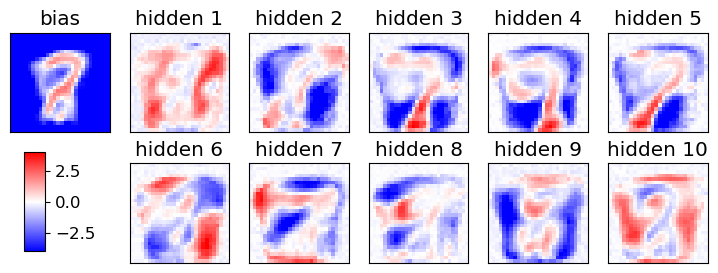

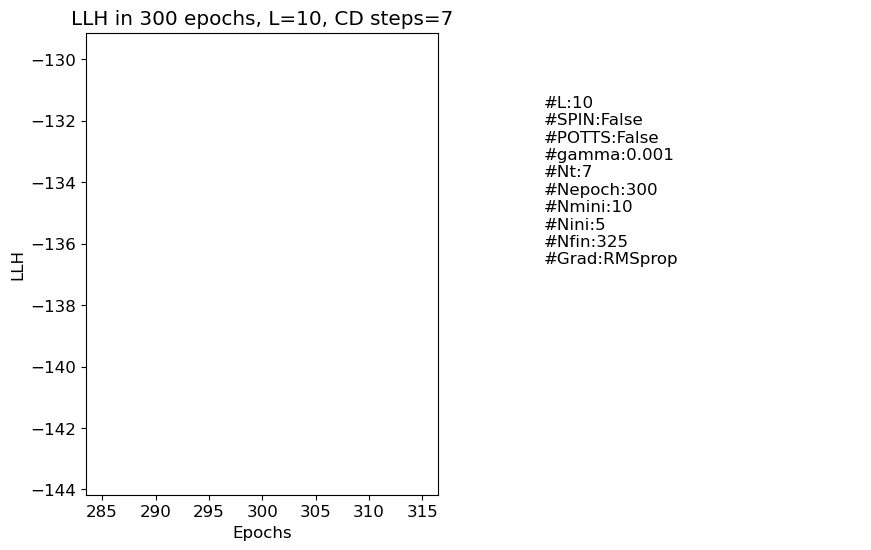

END of learning phase
Nepoch=300
Nmini=10


<Figure size 640x480 with 0 Axes>

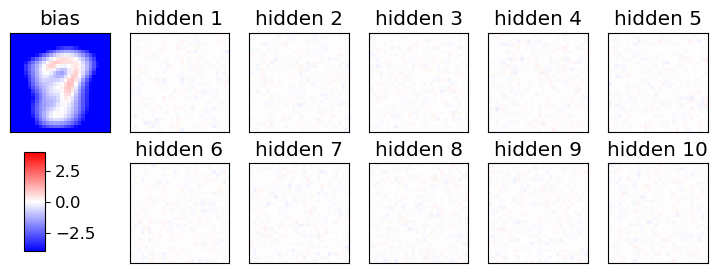

Starting the training
[18689 15116 18536 19331 14887]
[ 1719 12743  9533  8471   440]
[11610 10565 10559  2614  7288]
[13215 10535 20226 20202  1886]
epoch 1 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 6 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 9 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 10 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 11 

<Figure size 640x480 with 0 Axes>

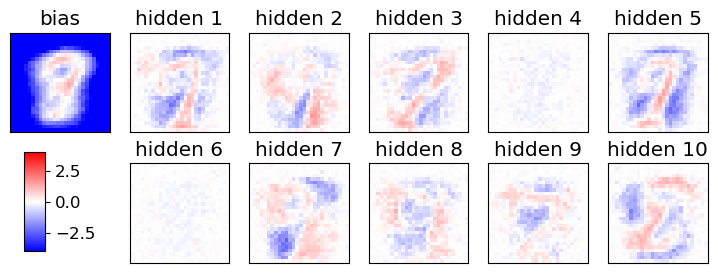

epoch 21 / 300  Nt: 7  N: 6  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 300  Nt: 7  N: 6  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 300  Nt: 7  N: 6  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 300  Nt: 7  N: 6  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 300  Nt: 7  N: 7  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 26 / 300  Nt: 7  N: 7  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 300  Nt: 7  N: 7  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 300  Nt: 7  N: 7  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 300  Nt: 7  N: 7  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 300  Nt: 7  N: 8  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 31 / 300  Nt: 7  N: 8  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 32 / 300  Nt: 7  N: 8  L: 10  rate: 0.05  gam: 0.001 SPINS=

<Figure size 640x480 with 0 Axes>

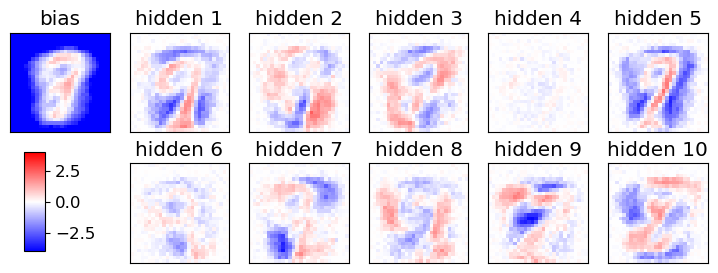

epoch 41 / 300  Nt: 7  N: 10  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 300  Nt: 7  N: 11  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 300  Nt: 7  N: 11  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 300  Nt: 7  N: 11  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 300  Nt: 7  N: 11  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 46 / 300  Nt: 7  N: 12  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 300  Nt: 7  N: 12  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 300  Nt: 7  N: 12  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 300  Nt: 7  N: 13  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 300  Nt: 7  N: 13  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 51 / 300  Nt: 7  N: 13  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 52 / 300  Nt: 7  N: 14  L: 10  rate: 0.05  gam: 

<Figure size 640x480 with 0 Axes>

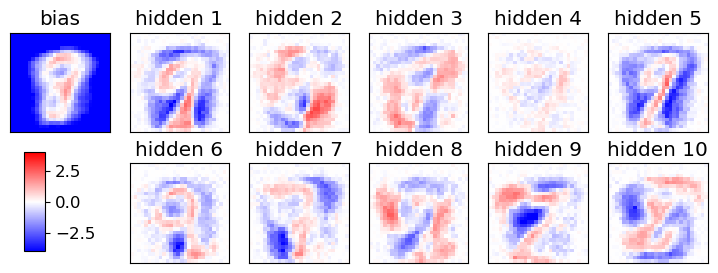

epoch 61 / 300  Nt: 7  N: 17  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 300  Nt: 7  N: 18  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 300  Nt: 7  N: 18  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 300  Nt: 7  N: 19  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 300  Nt: 7  N: 19  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 66 / 300  Nt: 7  N: 20  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 300  Nt: 7  N: 20  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 300  Nt: 7  N: 21  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 300  Nt: 7  N: 21  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 300  Nt: 7  N: 22  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 71 / 300  Nt: 7  N: 22  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 72 / 300  Nt: 7  N: 23  L: 10  rate: 0.05  gam: 

<Figure size 640x480 with 0 Axes>

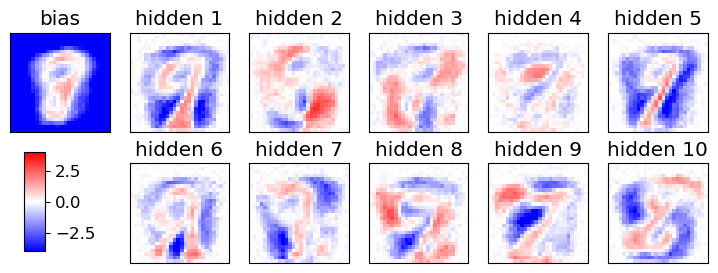

epoch 81 / 300  Nt: 7  N: 27  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 300  Nt: 7  N: 28  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 300  Nt: 7  N: 29  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 300  Nt: 7  N: 29  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 300  Nt: 7  N: 30  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 86 / 300  Nt: 7  N: 30  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 300  Nt: 7  N: 31  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 300  Nt: 7  N: 32  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 300  Nt: 7  N: 32  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 300  Nt: 7  N: 33  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 91 / 300  Nt: 7  N: 33  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 92 / 300  Nt: 7  N: 34  L: 10  rate: 0.05  gam: 

<Figure size 640x480 with 0 Axes>

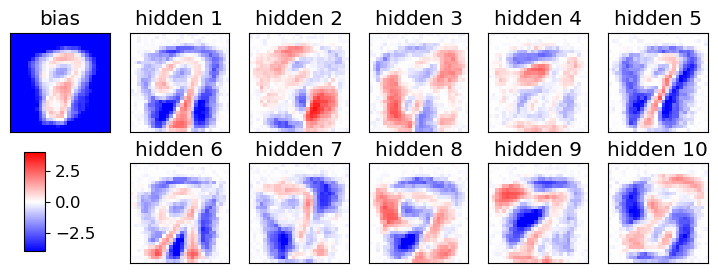

epoch 101 / 300  Nt: 7  N: 40  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 300  Nt: 7  N: 41  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 300  Nt: 7  N: 42  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 300  Nt: 7  N: 42  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 300  Nt: 7  N: 43  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 106 / 300  Nt: 7  N: 44  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 300  Nt: 7  N: 45  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 300  Nt: 7  N: 45  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 300  Nt: 7  N: 46  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 300  Nt: 7  N: 47  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 111 / 300  Nt: 7  N: 48  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 112 / 300  Nt: 7  N: 49  L: 10  rate:

<Figure size 640x480 with 0 Axes>

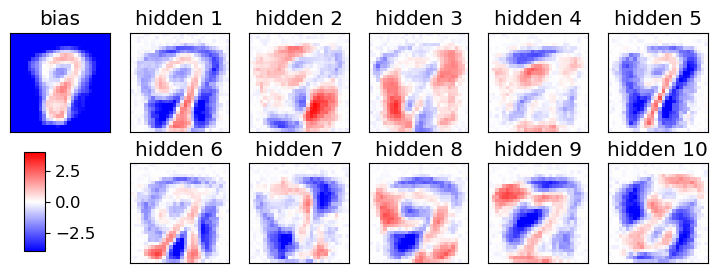

epoch 121 / 300  Nt: 7  N: 56  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 300  Nt: 7  N: 57  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 300  Nt: 7  N: 58  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 300  Nt: 7  N: 59  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 300  Nt: 7  N: 60  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 126 / 300  Nt: 7  N: 60  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 300  Nt: 7  N: 61  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 300  Nt: 7  N: 62  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 300  Nt: 7  N: 63  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 300  Nt: 7  N: 64  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 131 / 300  Nt: 7  N: 65  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 132 / 300  Nt: 7  N: 66  L: 10  rate:

<Figure size 640x480 with 0 Axes>

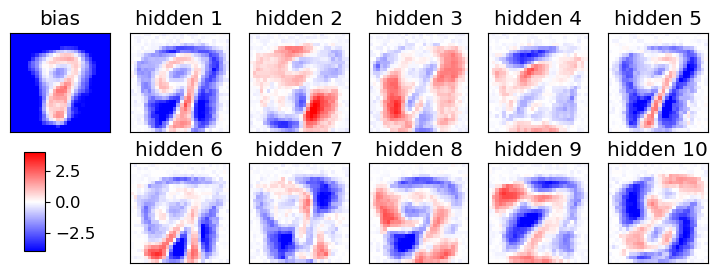

epoch 141 / 300  Nt: 7  N: 75  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 142 / 300  Nt: 7  N: 76  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 143 / 300  Nt: 7  N: 77  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 144 / 300  Nt: 7  N: 78  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 145 / 300  Nt: 7  N: 79  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 146 / 300  Nt: 7  N: 80  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 147 / 300  Nt: 7  N: 81  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 148 / 300  Nt: 7  N: 82  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 149 / 300  Nt: 7  N: 83  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 150 / 300  Nt: 7  N: 84  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 151 / 300  Nt: 7  N: 85  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 152 / 300  Nt: 7  N: 86  L: 10  rate:

<Figure size 640x480 with 0 Axes>

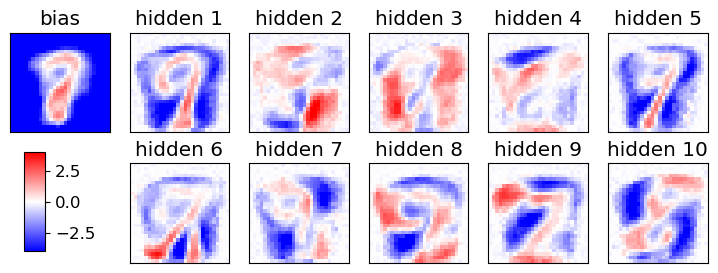

epoch 161 / 300  Nt: 7  N: 96  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 162 / 300  Nt: 7  N: 97  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 163 / 300  Nt: 7  N: 98  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 164 / 300  Nt: 7  N: 100  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 165 / 300  Nt: 7  N: 101  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 166 / 300  Nt: 7  N: 102  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 167 / 300  Nt: 7  N: 103  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 168 / 300  Nt: 7  N: 104  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 169 / 300  Nt: 7  N: 106  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 170 / 300  Nt: 7  N: 107  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 171 / 300  Nt: 7  N: 108  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 172 / 300  Nt: 7  N: 109  L: 

<Figure size 640x480 with 0 Axes>

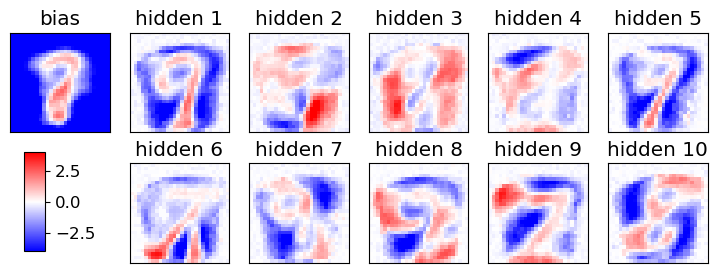

epoch 181 / 300  Nt: 7  N: 120  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 182 / 300  Nt: 7  N: 122  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 183 / 300  Nt: 7  N: 123  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 184 / 300  Nt: 7  N: 124  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 185 / 300  Nt: 7  N: 126  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 186 / 300  Nt: 7  N: 127  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 187 / 300  Nt: 7  N: 128  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 188 / 300  Nt: 7  N: 130  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 189 / 300  Nt: 7  N: 131  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 190 / 300  Nt: 7  N: 132  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 191 / 300  Nt: 7  N: 134  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 192 / 300  Nt: 7  N: 135  

<Figure size 640x480 with 0 Axes>

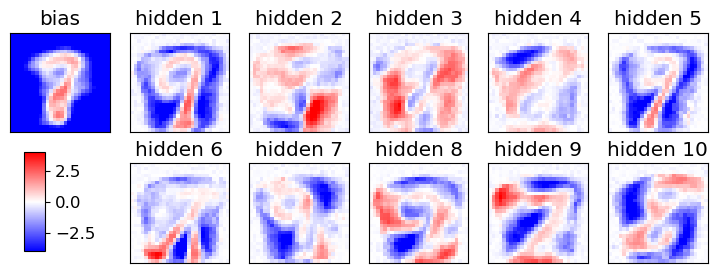

epoch 201 / 300  Nt: 7  N: 148  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 202 / 300  Nt: 7  N: 149  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 203 / 300  Nt: 7  N: 151  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 204 / 300  Nt: 7  N: 152  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 205 / 300  Nt: 7  N: 153  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 206 / 300  Nt: 7  N: 155  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 207 / 300  Nt: 7  N: 156  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 208 / 300  Nt: 7  N: 158  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 209 / 300  Nt: 7  N: 159  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 210 / 300  Nt: 7  N: 161  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 211 / 300  Nt: 7  N: 162  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 212 / 300  Nt: 7  N: 164  

<Figure size 640x480 with 0 Axes>

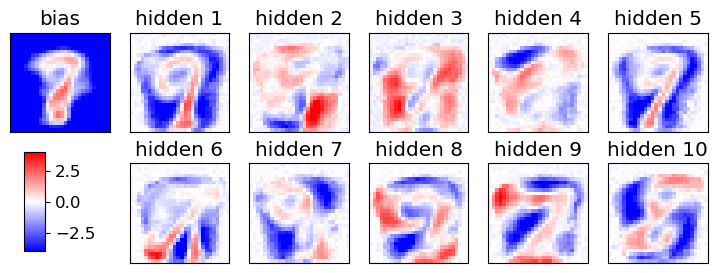

epoch 221 / 300  Nt: 7  N: 178  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 222 / 300  Nt: 7  N: 179  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 223 / 300  Nt: 7  N: 181  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 224 / 300  Nt: 7  N: 182  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 225 / 300  Nt: 7  N: 184  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 226 / 300  Nt: 7  N: 186  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 227 / 300  Nt: 7  N: 187  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 228 / 300  Nt: 7  N: 189  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 229 / 300  Nt: 7  N: 191  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 230 / 300  Nt: 7  N: 192  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 231 / 300  Nt: 7  N: 194  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 232 / 300  Nt: 7  N: 195  

<Figure size 640x480 with 0 Axes>

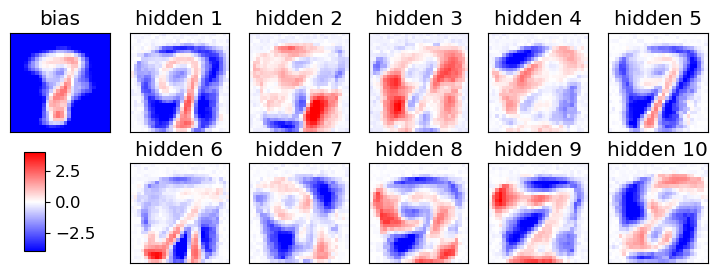

epoch 241 / 300  Nt: 7  N: 211  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 242 / 300  Nt: 7  N: 212  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 243 / 300  Nt: 7  N: 214  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 244 / 300  Nt: 7  N: 216  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 245 / 300  Nt: 7  N: 218  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 246 / 300  Nt: 7  N: 219  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 247 / 300  Nt: 7  N: 221  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 248 / 300  Nt: 7  N: 223  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 249 / 300  Nt: 7  N: 225  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 250 / 300  Nt: 7  N: 226  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 251 / 300  Nt: 7  N: 228  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 252 / 300  Nt: 7  N: 230  

<Figure size 640x480 with 0 Axes>

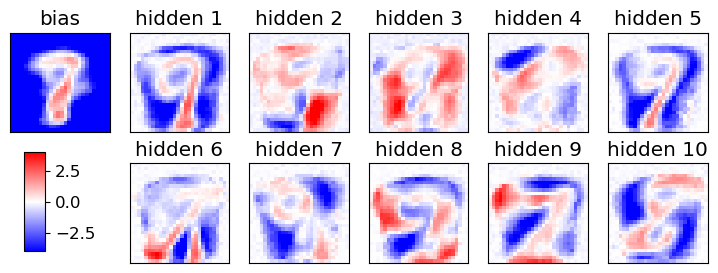

epoch 261 / 300  Nt: 7  N: 246  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 262 / 300  Nt: 7  N: 248  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 263 / 300  Nt: 7  N: 250  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 264 / 300  Nt: 7  N: 252  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 265 / 300  Nt: 7  N: 254  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 266 / 300  Nt: 7  N: 256  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 267 / 300  Nt: 7  N: 258  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 268 / 300  Nt: 7  N: 260  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 269 / 300  Nt: 7  N: 262  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 270 / 300  Nt: 7  N: 264  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 271 / 300  Nt: 7  N: 265  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 272 / 300  Nt: 7  N: 267  

<Figure size 640x480 with 0 Axes>

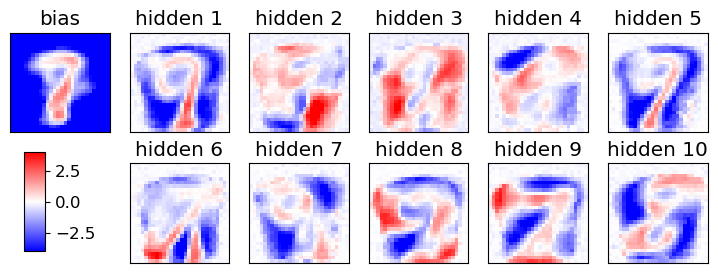

epoch 281 / 300  Nt: 7  N: 285  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 282 / 300  Nt: 7  N: 287  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 283 / 300  Nt: 7  N: 289  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 284 / 300  Nt: 7  N: 291  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 285 / 300  Nt: 7  N: 293  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 286 / 300  Nt: 7  N: 295  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 287 / 300  Nt: 7  N: 297  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 288 / 300  Nt: 7  N: 299  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 289 / 300  Nt: 7  N: 301  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 290 / 300  Nt: 7  N: 303  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 291 / 300  Nt: 7  N: 306  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 292 / 300  Nt: 7  N: 308  

<Figure size 640x480 with 0 Axes>

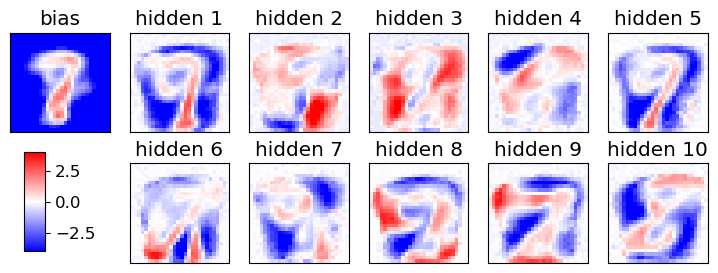

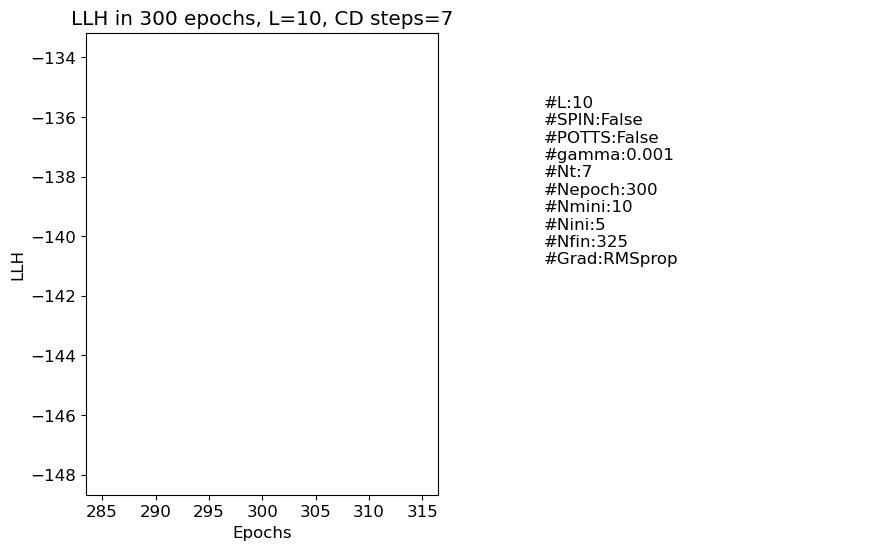

END of learning phase
Nepoch=300
Nmini=10


<Figure size 640x480 with 0 Axes>

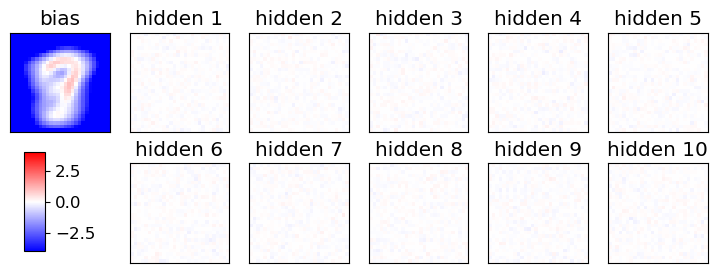

Starting the training
[15673   337 12060  9340 14732]
[14591  2843 15262 19739  4369]
[ 4309 20856  4510  3717 11261]
[14987 16872  3018 20623 18543]
epoch 1 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 2 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 3 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 4 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 5 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 6 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 7 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 8 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 9 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 10 / 300  Nt: 7  N: 5  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 11 

<Figure size 640x480 with 0 Axes>

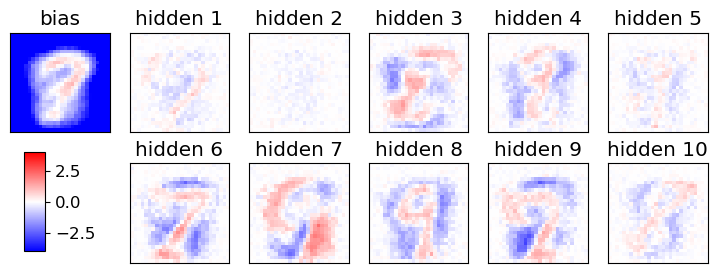

epoch 21 / 300  Nt: 7  N: 6  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 22 / 300  Nt: 7  N: 6  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 23 / 300  Nt: 7  N: 6  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 24 / 300  Nt: 7  N: 6  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 25 / 300  Nt: 7  N: 7  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 26 / 300  Nt: 7  N: 7  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 27 / 300  Nt: 7  N: 7  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 28 / 300  Nt: 7  N: 7  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 29 / 300  Nt: 7  N: 7  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 30 / 300  Nt: 7  N: 8  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 31 / 300  Nt: 7  N: 8  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 32 / 300  Nt: 7  N: 8  L: 10  rate: 0.05  gam: 0.001 SPINS=

<Figure size 640x480 with 0 Axes>

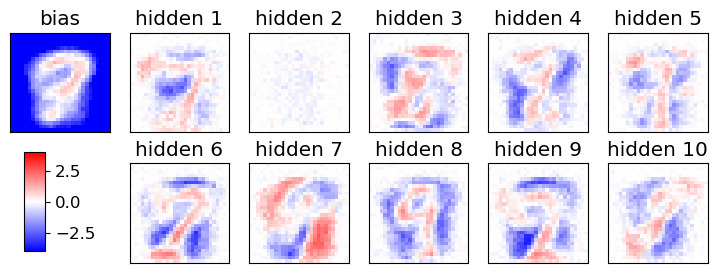

epoch 41 / 300  Nt: 7  N: 10  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 42 / 300  Nt: 7  N: 11  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 43 / 300  Nt: 7  N: 11  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 44 / 300  Nt: 7  N: 11  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 45 / 300  Nt: 7  N: 11  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 46 / 300  Nt: 7  N: 12  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 47 / 300  Nt: 7  N: 12  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 48 / 300  Nt: 7  N: 12  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 49 / 300  Nt: 7  N: 13  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 50 / 300  Nt: 7  N: 13  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 51 / 300  Nt: 7  N: 13  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 52 / 300  Nt: 7  N: 14  L: 10  rate: 0.05  gam: 

<Figure size 640x480 with 0 Axes>

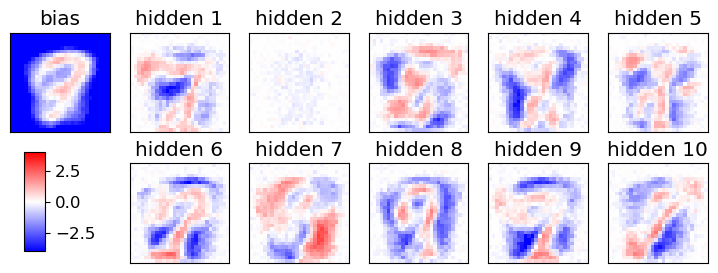

epoch 61 / 300  Nt: 7  N: 17  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 62 / 300  Nt: 7  N: 18  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 63 / 300  Nt: 7  N: 18  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 64 / 300  Nt: 7  N: 19  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 65 / 300  Nt: 7  N: 19  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 66 / 300  Nt: 7  N: 20  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 67 / 300  Nt: 7  N: 20  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 68 / 300  Nt: 7  N: 21  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 69 / 300  Nt: 7  N: 21  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 70 / 300  Nt: 7  N: 22  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 71 / 300  Nt: 7  N: 22  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 72 / 300  Nt: 7  N: 23  L: 10  rate: 0.05  gam: 

<Figure size 640x480 with 0 Axes>

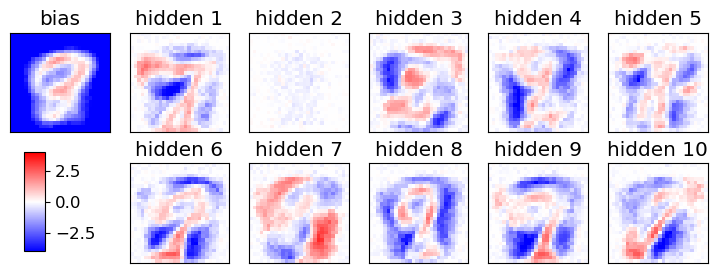

epoch 81 / 300  Nt: 7  N: 27  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 82 / 300  Nt: 7  N: 28  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 83 / 300  Nt: 7  N: 29  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 84 / 300  Nt: 7  N: 29  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 85 / 300  Nt: 7  N: 30  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 86 / 300  Nt: 7  N: 30  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 87 / 300  Nt: 7  N: 31  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 88 / 300  Nt: 7  N: 32  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 89 / 300  Nt: 7  N: 32  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 90 / 300  Nt: 7  N: 33  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 91 / 300  Nt: 7  N: 33  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 92 / 300  Nt: 7  N: 34  L: 10  rate: 0.05  gam: 

<Figure size 640x480 with 0 Axes>

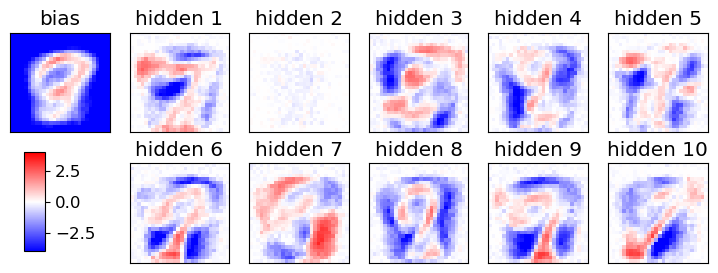

epoch 101 / 300  Nt: 7  N: 40  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 102 / 300  Nt: 7  N: 41  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 103 / 300  Nt: 7  N: 42  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 104 / 300  Nt: 7  N: 42  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 105 / 300  Nt: 7  N: 43  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 106 / 300  Nt: 7  N: 44  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 107 / 300  Nt: 7  N: 45  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 108 / 300  Nt: 7  N: 45  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 109 / 300  Nt: 7  N: 46  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 110 / 300  Nt: 7  N: 47  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 111 / 300  Nt: 7  N: 48  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 112 / 300  Nt: 7  N: 49  L: 10  rate:

<Figure size 640x480 with 0 Axes>

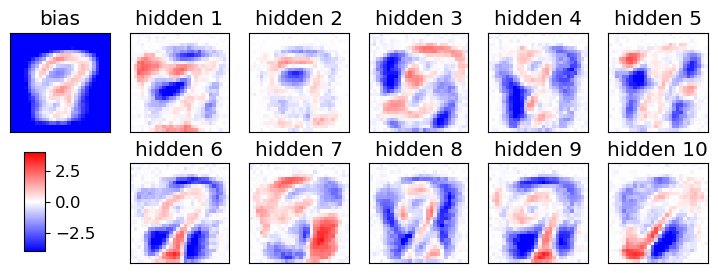

epoch 121 / 300  Nt: 7  N: 56  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 122 / 300  Nt: 7  N: 57  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 123 / 300  Nt: 7  N: 58  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 124 / 300  Nt: 7  N: 59  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 125 / 300  Nt: 7  N: 60  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 126 / 300  Nt: 7  N: 60  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 127 / 300  Nt: 7  N: 61  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 128 / 300  Nt: 7  N: 62  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 129 / 300  Nt: 7  N: 63  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 130 / 300  Nt: 7  N: 64  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 131 / 300  Nt: 7  N: 65  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 132 / 300  Nt: 7  N: 66  L: 10  rate:

<Figure size 640x480 with 0 Axes>

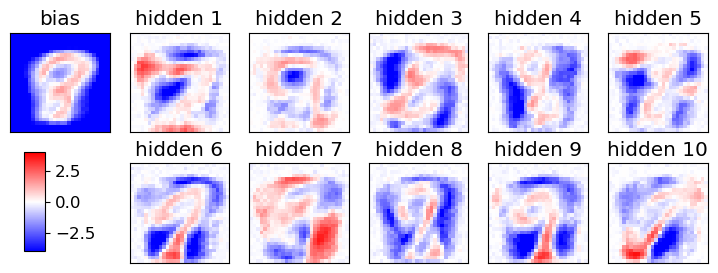

epoch 141 / 300  Nt: 7  N: 75  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 142 / 300  Nt: 7  N: 76  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 143 / 300  Nt: 7  N: 77  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 144 / 300  Nt: 7  N: 78  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 145 / 300  Nt: 7  N: 79  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 146 / 300  Nt: 7  N: 80  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 147 / 300  Nt: 7  N: 81  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 148 / 300  Nt: 7  N: 82  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 149 / 300  Nt: 7  N: 83  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 150 / 300  Nt: 7  N: 84  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 151 / 300  Nt: 7  N: 85  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 152 / 300  Nt: 7  N: 86  L: 10  rate:

<Figure size 640x480 with 0 Axes>

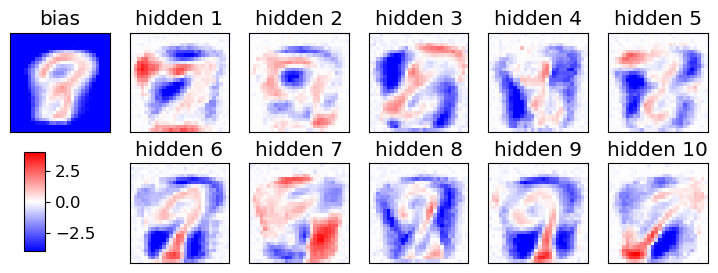

epoch 161 / 300  Nt: 7  N: 96  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 162 / 300  Nt: 7  N: 97  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 163 / 300  Nt: 7  N: 98  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 164 / 300  Nt: 7  N: 100  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 165 / 300  Nt: 7  N: 101  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 166 / 300  Nt: 7  N: 102  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 167 / 300  Nt: 7  N: 103  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 168 / 300  Nt: 7  N: 104  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 169 / 300  Nt: 7  N: 106  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 170 / 300  Nt: 7  N: 107  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 171 / 300  Nt: 7  N: 108  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 172 / 300  Nt: 7  N: 109  L: 

<Figure size 640x480 with 0 Axes>

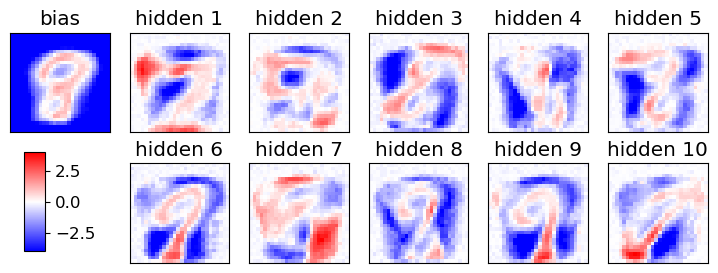

epoch 181 / 300  Nt: 7  N: 120  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 182 / 300  Nt: 7  N: 122  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 183 / 300  Nt: 7  N: 123  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 184 / 300  Nt: 7  N: 124  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 185 / 300  Nt: 7  N: 126  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 186 / 300  Nt: 7  N: 127  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 187 / 300  Nt: 7  N: 128  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 188 / 300  Nt: 7  N: 130  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 189 / 300  Nt: 7  N: 131  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 190 / 300  Nt: 7  N: 132  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 191 / 300  Nt: 7  N: 134  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 192 / 300  Nt: 7  N: 135  

<Figure size 640x480 with 0 Axes>

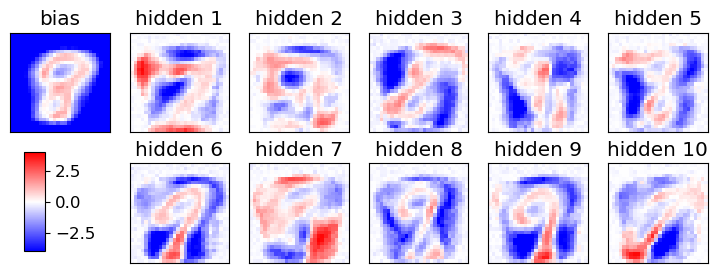

epoch 201 / 300  Nt: 7  N: 148  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 202 / 300  Nt: 7  N: 149  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 203 / 300  Nt: 7  N: 151  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 204 / 300  Nt: 7  N: 152  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 205 / 300  Nt: 7  N: 153  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 206 / 300  Nt: 7  N: 155  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 207 / 300  Nt: 7  N: 156  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 208 / 300  Nt: 7  N: 158  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 209 / 300  Nt: 7  N: 159  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 210 / 300  Nt: 7  N: 161  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 211 / 300  Nt: 7  N: 162  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 212 / 300  Nt: 7  N: 164  

<Figure size 640x480 with 0 Axes>

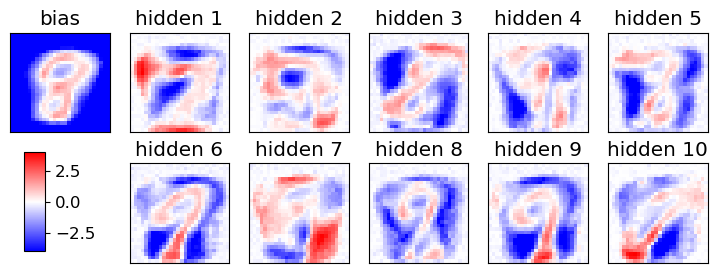

epoch 221 / 300  Nt: 7  N: 178  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 222 / 300  Nt: 7  N: 179  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 223 / 300  Nt: 7  N: 181  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 224 / 300  Nt: 7  N: 182  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 225 / 300  Nt: 7  N: 184  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 226 / 300  Nt: 7  N: 186  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 227 / 300  Nt: 7  N: 187  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 228 / 300  Nt: 7  N: 189  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 229 / 300  Nt: 7  N: 191  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 230 / 300  Nt: 7  N: 192  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 231 / 300  Nt: 7  N: 194  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 232 / 300  Nt: 7  N: 195  

<Figure size 640x480 with 0 Axes>

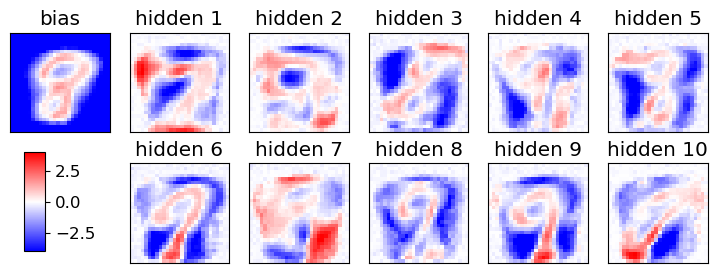

epoch 241 / 300  Nt: 7  N: 211  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 242 / 300  Nt: 7  N: 212  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 243 / 300  Nt: 7  N: 214  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 244 / 300  Nt: 7  N: 216  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 245 / 300  Nt: 7  N: 218  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 246 / 300  Nt: 7  N: 219  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 247 / 300  Nt: 7  N: 221  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 248 / 300  Nt: 7  N: 223  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 249 / 300  Nt: 7  N: 225  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 250 / 300  Nt: 7  N: 226  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 251 / 300  Nt: 7  N: 228  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 252 / 300  Nt: 7  N: 230  

<Figure size 640x480 with 0 Axes>

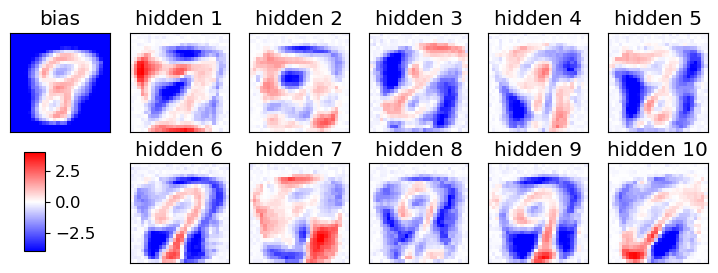

epoch 261 / 300  Nt: 7  N: 246  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 262 / 300  Nt: 7  N: 248  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 263 / 300  Nt: 7  N: 250  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 264 / 300  Nt: 7  N: 252  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 265 / 300  Nt: 7  N: 254  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 266 / 300  Nt: 7  N: 256  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 267 / 300  Nt: 7  N: 258  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 268 / 300  Nt: 7  N: 260  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 269 / 300  Nt: 7  N: 262  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 270 / 300  Nt: 7  N: 264  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 271 / 300  Nt: 7  N: 265  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 272 / 300  Nt: 7  N: 267  

<Figure size 640x480 with 0 Axes>

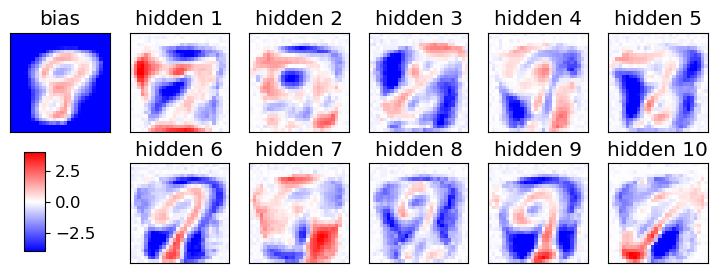

epoch 281 / 300  Nt: 7  N: 285  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 282 / 300  Nt: 7  N: 287  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 283 / 300  Nt: 7  N: 289  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 284 / 300  Nt: 7  N: 291  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 285 / 300  Nt: 7  N: 293  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 286 / 300  Nt: 7  N: 295  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 287 / 300  Nt: 7  N: 297  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 288 / 300  Nt: 7  N: 299  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 289 / 300  Nt: 7  N: 301  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 290 / 300  Nt: 7  N: 303  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 291 / 300  Nt: 7  N: 306  L: 10  rate: 0.05  gam: 0.001 SPINS= False POTTS= False
epoch 292 / 300  Nt: 7  N: 308  

In [ ]:
for seed in [12, 123, 1234, 12345, 123456, 1234568]:
    (rdseed := np.random.seed(seed))
    ## INitial things ---> sigma tuning also??
    
    # initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
    w = sigma * np.random.randn(D,L)
    #a = sigma * np.random.randn(D)
    # using Hinton initialization of visible biases
    a = Hinton_bias_init(data)
    # hidden biases initialized to zero
    b = np.zeros(L)
    print(f"Nepoch={Nepoch}\nNmini={Nmini}")
    # recording history of weights ("E" means epoch)
    wE,aE,bE=np.zeros((Nepoch+1,D,L)),np.zeros((Nepoch+1,D)),np.zeros((Nepoch+1,L)) 
    wE[0],aE[0],bE[0]=np.copy(w),np.copy(a),np.copy(b)
    gwE,gw2E,gwE_d,gwE_m = np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE),np.zeros_like(wE)
    gaE,ga2E,gaE_d,gaE_m = np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE),np.zeros_like(aE)
    gbE,gb2E,gbE_d,gbE_m = np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE),np.zeros_like(bE)
    miniE = np.zeros(Nepoch+1)
    pzE=np.zeros((Nepoch+1,Nz))
    
    if GRAD=="RMSprop": 
        gw2,ga2,gb2 = np.zeros_like(w),np.zeros_like(a),np.zeros_like(b)
    
    indices=np.arange(Nd).astype("int")
    plot_weights_bias(wE, aE, 0, L, cols=L//2, save=False)
    
    # for the plot with panels
    Ncols=min(8,max(2,L//2))
    
    if POTTS: print("Starting the training, POTTS=True")
    else: print("Starting the training")
    #for L in np.arange(4,9,1):
    
    configurations = generate_configurations(L)
    log_likelihoods = []
    lista_epoch_grafico = []
    # Note: here an epoch does not analyze the whole dataset
    for epoch in range(1,1+Nepoch):
        # q maps epochs to interval [0,1]
        q = (epoch-1.)/(Nepoch-1.) 
        # N, size of the mini batch
        # stays closer to N_ini for some time, then it progressively accelerates toward N_fin
        N = int(N_ini + (N_fin-N_ini)*(q**2))
        #  l_rate interpolates between initial and final value
        l_rate = l_rate_ini + (l_rate_fin-l_rate_ini)*q
    
        for mini in range(Nmini):
            # initializitation for averages in minibatch
            # visible variables "v" --> "x"
            #  hidden variables "h" --> "z"
            x_data, x_model = np.zeros(D),np.zeros(D)
            z_data, z_model = np.zeros(L),np.zeros(L)
            xz_data,xz_model= np.zeros((D,L)),np.zeros((D,L))
            pz = np.zeros(L)
    
            # Minibatch of size N: points randomply picked (without repetition) from data
            selected = np.random.choice(indices,N,replace=False)
            if epoch==1 and mini<=3: print(selected)
    
            for k in range(N):
                ###################################
                x0 = data[selected[k]]
                # positive CD phase: generating z from x[k]
                z = CD_step(x0,w,b,POTTS=POTTS)
                x_data  += x0
                z_data  += z
                xz_data += np.outer(x0,z)
                # fantasy
                zf=np.copy(z)
                # Contrastive divergence with Nt steps
                for t in range(Nt):
                    # negative CD pzase: generating fantasy xf from fantasy zf
                    xf = CD_step(zf,w.T,a)
                    # positive CD phase: generating fantasy zf from fantasy xf 
                    zf = CD_step(xf,w,b,POTTS=POTTS)
                x_model += xf
                z_model += zf
                xz_model+= np.outer(xf,zf)
                # recording probability of encoding in z-space, if POTTS
                if POTTS: pz[zf]+=1
                ###################################
    
            # gradient of the likelihood: follow it along its positive direction
            gw_d,gw_m = xz_data/N, xz_model/N
            ga_d,ga_m = x_data/N, x_model/N
            gb_d,gb_m = z_data/N, z_model/N
            gw=np.copy(gw_d - gw_m)
            ga=np.copy(ga_d - ga_m)
            gb=np.copy(gb_d - gb_m)
    
            # gradient ascent step
            if GRAD=="RMSprop":
                # RMSprop gradient ascent
                gw2 = beta*gw2+(1-beta)*np.square(gw)
                ga2 = beta*ga2+(1-beta)*np.square(ga)
                gb2 = beta*gb2+(1-beta)*np.square(gb)
                w += l_rate*gw/sqrt(epsilon+gw2)
                a += l_rate*ga/sqrt(epsilon+ga2)
                b += l_rate*gb/sqrt(epsilon+gb2)
            else: 
                # defaulting to the vanilla stochastic gradient ascent (SGD)
                w += l_rate*gw
                a += l_rate*ga
                b += l_rate*gb
            # regularization (LASSO)
            if gamma>0.:
                w -= (gamma*l_rate)*sign(w)
                a -= (gamma*l_rate)*sign(a)
                b -= (gamma*l_rate)*sign(b)
    
        wE[epoch],gwE[epoch],gwE_d[epoch],gwE_m[epoch]=np.copy(w),np.copy(gw),np.copy(gw_d),np.copy(gw_m)
        aE[epoch],gaE[epoch],gaE_d[epoch],gaE_m[epoch]=np.copy(a),np.copy(ga),np.copy(ga_d),np.copy(ga_m)
        bE[epoch],gbE[epoch],gbE_d[epoch],gbE_m[epoch]=np.copy(b),np.copy(gb),np.copy(gb_d),np.copy(gb_m)
        miniE[epoch]=N
        if POTTS: pzE[epoch] = pz/np.sum(pz)
        print("epoch",epoch,"/",Nepoch," Nt:",Nt," N:",N," L:",L,
              " rate:",l_rate," gam:",gamma,"SPINS=",SPINS,"POTTS=",POTTS)
    
        if Nepoch<=100 or epoch%20==0 or epoch==Nepoch:
            plot_weights_bias(wE, aE, epoch, L, cols=Ncols, save=False)
    
        if epoch==(Nepoch):
            partition = partition_function(configurations)
            log_likelihood = compute_log_likelihood(partition,data, a=a, b=b, w=w,)
            log_likelihoods.append(log_likelihood)
            lista_epoch_grafico.append(epoch)
            with open('llh.txt', 'a') as add:
                print(log_likelihood, file=add)
        str_time_completion = datetime.datetime.now().strftime("_%Y%m%d_%H%M")
    
    fig, ax = plt.subplots(1,2, figsize=(10,6))
    plt.sca(ax[0])
    plt.plot(lista_epoch_grafico, log_likelihoods, '-')
    plt.title(f'LLH in {Nepoch} epochs, L={L}, CD steps={Nt}')
    plt.xlabel('Epochs')
    plt.ylabel('LLH')
    plt.sca(ax[1])
    plt.text(0.1,0.5, stringa)
    plt.axis('off')
    
    
    plt.savefig(f'img/CV/rdseed_{rdseed}_LLH_epoch{Nepoch}_L{L}_CD{Nt}.png')
    plt.show()
    print("END of learning phase")

## Test generative power of the trained RBM

In [ ]:
ee=-1 ##
NN=200
traj_x,traj_z = np.zeros((NN+2,D)), np.zeros((NN+2,L))
xf=np.copy(data[np.random.randint(Nd)])
traj_x[0]=np.copy(xf)

# AF: multiply weights and biases by a number >1 to achieve a more deterministic behavior,
# equivalent to lower the temperature in a Boltzmann weight -> select lowest energies
# Note: here, this is done in the negative CD step only
AF=1.

for t in range(NN):
    t1=t+1
    # positive CD phase: generating fantasy zf from fantasy xf
    zf = CD_step(xf,1*wE[ee],1*bE[ee],POTTS=POTTS)
    traj_z[t] = np.copy(zf)
    # negative CD pzase: generating fantasy xf from fantasy zf
    xf = CD_step(zf,AF*wE[ee].T,AF*aE[ee])
    traj_x[t1] = np.copy(xf)


plot_weights_bias(wE, aE, Nepoch, L, cols=Ncols, save=False)

col0,col1,col2,col3,col4=(0.8,0,0,1),(1,0.6,0,1),(0,.7,0,1),(0.2,0.2,1,1),(1,0,1,1)
show_MNIST(traj_x[0:],Nex=10,colors=(col0,col1))
show_MNIST(traj_x[10:],Nex=10,colors=(col1,col2))
show_MNIST(traj_x[20:],Nex=10,colors=(col2,col3))
show_MNIST(traj_x[40:],Nex=10,colors=(col3,col4))
print("L:",L,"    amplification of weights:",AF)

## Plot of the gradient amplitude

NE= 100


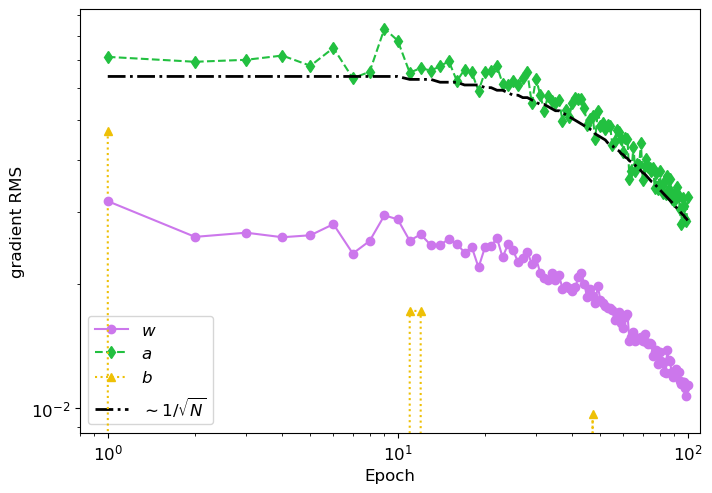

FIG/RBM_grad_MNIST3_E100_N30-150_RMSprop-0.05-0.05_CD-1_L7_reg0.01.png


In [75]:
def make_fname(strin):
    fname="FIG/RBM_"+strin+"_MNIST"+str(Ndigit)+"_E"+str(NE)+"_N"+str(N_ini)+"-"+str(N_fin)
    fname=fname+"_"+GRAD+"-"+str(l_rate_ini)+"-"+str(l_rate_fin)+"_CD-"+str(Nt)+"_L"+str(L)
    if gamma>0:  fname=fname+"_reg"+str(gamma)
    return fname+".png"

NE = len(gwE)-1
print("NE=",NE)
mgw,mga,mgb,epo=np.zeros(NE),np.zeros(NE),np.zeros(NE),np.zeros(NE)
DE=1
if NE>30: DE=2
if NE>50: DE=5
if NE>100: DE=10
# compute RMS average of gradients during epochs
for ep in range(1,1+NE):
    epo[ep-1]=ep
    mgw[ep-1] = np.std(gwE[ep])
    mga[ep-1] = np.std(gaE[ep])
    mgb[ep-1] = np.std(gbE[ep])

#############################################################################
# creating grid for subplots
fig, ax = plt.subplots(1, 1, figsize=(8,5.5))
fig.subplots_adjust( left=None, bottom=None,  right=None, top=None, wspace=None, hspace=None)
        
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(DE))
ax.plot(epo,mgw,"o-",c="#CC77EC",label="$w$",zorder=10)
ax.plot(epo,mga,"d--",c="#22C040",label="$a$",zorder=5)
ax.plot(epo,mgb,"^:",c="#EEC006",label="$b$",zorder=8)
ax.plot(epo,.35/sqrt(miniE[1:]),"k-.",label="$\\sim 1 / \\sqrt{N}$",zorder=20,lw=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("gradient RMS")
ax.set_xlim(0.5,NE+0.5)
if 1==2: ax.set_ylim(0,)
else: 
    ax.set_xlim(0.8,Nepoch*1.1)
    ax.set_xscale("log")
    ax.set_yscale("log")
ax.legend()

fname=make_fname("grad")
fig.savefig(fname,dpi=200,bbox_inches='tight',pad_inches=0.02, transparent=False)
plt.show()
print(fname)

## Save weights over epochs on file

In [76]:
def make_weights_fname(label,dname="WEIGHTS"):
    fname=dname+"/"+label+"_"+str_simul+"_MNIST"+str(Ndigit)+"_L"+str(L)
    fname=fname+"_"+GRAD+"-"+"{:.2f}".format(l_rate_ini)+"-"+"{:.2f}".format(l_rate_fin)+"_Ep"+str(Nepoch)
    if gamma>0:  fname=fname+"_reg"+"{:.3g}".format(gamma)
    if POTTS: fname+="_POTTS"
    if SPINS: fname+="_SPINS"
    fname=fname+str_time_completion
    return fname+".npy"

def save_epochs(qE,label):
    fname=make_weights_fname(label)
    print(fname)
    np.save(fname,qE)

save_epochs(wE,"w")
save_epochs(bE,"b")
save_epochs(aE,"a")

WEIGHTS/w_RBM_Potts_MNIST3_L7_RMSprop-0.05-0.05_Ep100_reg0.01_POTTS_20250320_1724.npy
WEIGHTS/b_RBM_Potts_MNIST3_L7_RMSprop-0.05-0.05_Ep100_reg0.01_POTTS_20250320_1724.npy
WEIGHTS/a_RBM_Potts_MNIST3_L7_RMSprop-0.05-0.05_Ep100_reg0.01_POTTS_20250320_1724.npy


# RESULTS

#### 1. Initialization of biases

Explain the initialization of visible biases proposed by Hinton.

In [23]:
import os
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt

# Path to your images
folder_path = "img/"
files = [(f, os.path.getmtime(os.path.join(folder_path, f))) for f in os.listdir(folder_path)] #add thing that selects just .png
# Sort files by modification time (oldest first)
files_sorted = sorted(files, key=lambda x: x[1])

# Extract sorted file names
sorted_filenames = [f[0] for f in files_sorted]
sorted_filenames = sorted_filenames[:-2]


row,cols = 5,6
fig,axes = plt.subplots(row,cols, figsize=(15,10))
axes = axes.flatten()
for i, img in enumerate(sorted_filenames[:row*cols]):
    image = Image.open('img/' +img)
    axes[i].imshow(image)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

IsADirectoryError: [Errno 21] Is a directory: '/home/gigi/LCP-B/ex2/img/digit012'

#### 2. Log-likelihood

Take an RBM with L=3 hidden units and compute the log-likelihood L of data during training (see the notes). Does it grow during training? Does it depend on the number of contrastive divergence steps?  Then compare the log-likelihood L at the end of training for L=3, 4, 5, 6, … up to a maximum L of your choice.

We trained the RBM on digits 7,8,9, trying with number of hidden units L $\in [3,4,5,6,7]$, and for each value we tried different CD steps, $Nt \in [2,4,6,8,10,12]$.

Log-likelihood generally increases during training, what you can see in the resume above are graphs of the LL taken every 5 epochs to spare us computational time and get as soon as possible an overview.

What we see is that number of CD steps matters a little bit in LL increase, 2-3 points, and it depends more on the number of hidden units. Best final values are for L=7. It is interesting to see that sometimes LL stalls after a initial steep increase. We hope to find an explanation during phase of hyperparameter tuning.




cross validation: fixed hyperparameters, and multiple runs w/ different random seeds. and then mean and std of final LLH